In [11]:
import tensorflow as tf
print(tf.__version__)

2.19.0


In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, optimizers, callbacks
import tensorflow as tf
import os

# Configuration
IMAGE_SIZE = (8, 8)
BATCH_SIZE = 32
EPOCHS = 50
VAL_SPLIT = 0.2
CSV_PATH = 'F:/Education/NSU/CSE/CSE499/Implementation/Dataset/8x8 Matrix Metasurface/results.csv'
IMAGE_DIR = 'F:/Education/NSU/CSE/CSE499/Implementation/Dataset/8x8 Matrix Metasurface/matrix'
OUTPUT_DIR = 'F:/Education/NSU/CSE/CSE499/Implementation/Dataset/8x8 Matrix Metasurface/model_outputs'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load CSV data
df = pd.read_csv(CSV_PATH)
df['ID'] = df['ID'].astype(str)

# Pure-TF Data Augmentation Function
def tf_augment(image):
    """Native TensorFlow augmentation without any TFA dependencies"""
    # Random rotations (0°, 90°, 180°, 270°)
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    
    # Random flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    # Random zoom and crop
    zoom_factor = tf.random.uniform(shape=[], minval=0.9, maxval=1.1)
    new_size = tf.cast(tf.round(tf.cast(tf.shape(image)[:2], tf.float32) * zoom_factor), tf.int32)
    image = tf.image.resize(image, new_size)
    image = tf.image.resize_with_crop_or_pad(image, IMAGE_SIZE[0], IMAGE_SIZE[1])
    
    # Random brightness and contrast
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    
    return image


# 1. Data Cleaning Function (MISSING IN PREVIOUS IMPLEMENTATION)
def clean_dataframe(df):
    """Remove problematic rows and ensure numeric values"""
    # Make copy to avoid modifying original
    df_clean = df.copy()
    
    # Convert ID to string and clean
    df_clean['ID'] = df_clean['ID'].astype(str)
    
    # Convert parameter columns to numeric, coercing errors
    for col in df_clean.columns[1:]:  # Skip ID column
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
    
    # Drop rows with any NA values (from failed conversions)
    df_clean = df_clean.dropna()
    
    return df_clean

# 2. Corrected Data Generator
class CorrectedDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, image_dir, batch_size, target_size, shuffle=True):
        self.df = clean_dataframe(df).reset_index(drop=True)  # Now clean_dataframe is defined
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.df))
        super().__init__()  # Fixes the PyDataset warning
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        X = np.zeros((len(batch_indices), *self.target_size, 3))
        y = np.zeros((len(batch_indices), len(self.df.columns)-1))  # All params except ID
        
        for i, idx in enumerate(batch_indices):
            try:
                img_path = os.path.join(self.image_dir, f"image_{self.df.iloc[idx]['ID']}.png")
                img = tf.io.read_file(img_path)
                img = tf.image.decode_png(img, channels=3)
                img = tf.image.resize(img, self.target_size)
                X[i,] = tf.cast(img, tf.float32) / 255.0
                y[i,] = self.df.iloc[idx, 1:].values.astype('float32')
            except Exception as e:
                print(f"Skipping corrupt data at index {idx}: {str(e)}")
                continue
                
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

# 3. Verify your data first
df = pd.read_csv(CSV_PATH)
df_clean = clean_dataframe(df)
print(f"Original samples: {len(df)}, Clean samples: {len(df_clean)}")

# 4. Create generators
train_df, val_df = train_test_split(df_clean, test_size=VAL_SPLIT, random_state=42)
train_gen = CorrectedDataGenerator(train_df, IMAGE_DIR, BATCH_SIZE, IMAGE_SIZE)
val_gen = CorrectedDataGenerator(val_df, IMAGE_DIR, BATCH_SIZE, IMAGE_SIZE, shuffle=False)

Original samples: 600, Clean samples: 599


In [38]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

# 5. ViT Model Implementation
def create_vit_model(input_shape=(8,8,3), num_outputs=8):
    inputs = layers.Input(shape=input_shape)
    
    # Patch embedding
    x = layers.Conv2D(64, kernel_size=2, strides=2, activation="relu")(inputs)
    x = layers.Reshape((16, 64))(x)
    
    # Position embedding
    positions = tf.range(start=0, limit=16, delta=1)
    position_embedding = layers.Embedding(input_dim=16, output_dim=64)(positions)
    x = x + position_embedding
    
    # Transformer blocks
    for _ in range(4):
        # Self-attention
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        attn_output = layers.MultiHeadAttention(num_heads=4, key_dim=16)(x, x)
        x = x + attn_output
        
        # MLP
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        mlp = layers.Dense(64, activation="gelu")(x)
        x = x + mlp
    
    # Output
    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(num_outputs)(x)
    
    return models.Model(inputs, outputs)

# 6. Compile and train
vit_model = create_vit_model()
vit_model.compile(
    optimizer=optimizers.Adam(3e-4),
    loss='mse',
    metrics=['mae']
)

vit_history = vit_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=100,
    callbacks=[
        callbacks.EarlyStopping(patience=10),
        callbacks.ModelCheckpoint('vit_best.h5', save_best_only=True)
    ]
)


# Model summary
vit_model.summary()

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 78.8804 - mae: 5.3019

15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 119ms/step - loss: 78.1198 - mae: 5.2817 - val_loss: 45.4861 - val_mae: 4.3578
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 36.4911 - mae: 3.9201

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 36.1520 - mae: 3.8993 - val_loss: 21.6252 - val_mae: 2.9098
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 16.9573 - mae: 2.5720

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 16.7766 - mae: 2.5564 - val_loss: 10.2351 - val_mae: 1.9424
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 7.7759 - mae: 1.6842

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 7.7012 - mae: 1.6741 - val_loss: 5.4550 - val_mae: 1.2760
Epoch 5/100
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 3.7282 - mae: 1.0758

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 3.6772 - mae: 1.0634 - val_loss: 3.1306 - val_mae: 0.8639
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 2.0056 - mae: 0.7389

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 1.9938 - mae: 0.7345 - val_loss: 2.0533 - val_mae: 0.6188
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.1037 - mae: 0.5156

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 1.1088 - mae: 0.5145 - val_loss: 1.6457 - val_mae: 0.5020
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.1361 - mae: 0.4722

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.1280 - mae: 0.4705 - val_loss: 1.5145 - val_mae: 0.4605
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.8948 - mae: 0.4179

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.8992 - mae: 0.4181 - val_loss: 1.4877 - val_mae: 0.4589
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.9037 - mae: 0.4230

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.9074 - mae: 0.4228 - val_loss: 1.4779 - val_mae: 0.4540
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.0732 - mae: 0.4369

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 1.0662 - mae: 0.4360 - val_loss: 1.4768 - val_mae: 0.4496
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.8599 - mae: 0.4181 - val_loss: 1.4781 - val_mae: 0.4569
Epoch 13/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.8820 - mae: 0.4224 - val_loss: 1.4777 - val_mae: 0.4533
Epoch 14/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 1.1601 - mae: 0.4269 - val_loss: 1.4792 - val_mae: 0.4488
Epoch 15/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.8038 - mae: 0.4074 - val_loss: 1.4805 - val_mae: 0.4570
Epoch 16/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.8784 - mae: 0.4187 - val_loss: 1.4805 - val_mae: 0.4617
Epoch 17/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 1.3297 - mae: 0.4383 - val_loss: 1.4830 - val_mae: 0.4534
Epoch 18/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.8062 - mae: 0.4123 - val_loss: 1.4789 - val_mae: 0.4562
Epoch 19/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.8665 - mae: 0.4150 - val_loss: 1.4762 - val_mae: 0.4510
Epoch 20/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.9232 - mae: 0.4299 - val_loss: 1.4823 - val_mae: 0.4583
Epoch 21/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.8131 - mae: 0.4015 - val_loss: 1.4777 - val_mae: 0.4593
Epoch 22/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.7694 - mae: 0.4085 - val_loss: 1.4785 - val_mae: 0.4506
Epoch 23/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.8363 - mae: 0.4181 - val_loss: 1.4763 - val_mae: 0.4543
Epoch 24/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.7952 - mae: 0.4103 - val_loss: 1.4842 - val_mae: 0.4628
Epoch 25/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.7670 - mae: 0.4196

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.7790 - mae: 0.4200 - val_loss: 1.4740 - val_mae: 0.4537
Epoch 26/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.8965 - mae: 0.4234 - val_loss: 1.4802 - val_mae: 0.4572
Epoch 27/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 1.2247 - mae: 0.4389

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 1.2079 - mae: 0.4377 - val_loss: 1.4718 - val_mae: 0.4511
Epoch 28/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.9126 - mae: 0.4172 - val_loss: 1.4821 - val_mae: 0.4616
Epoch 29/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.9387 - mae: 0.4273 - val_loss: 1.4736 - val_mae: 0.4550
Epoch 30/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.8895 - mae: 0.4120 - val_loss: 1.4838 - val_mae: 0.4776
Epoch 31/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 1.3436 - mae: 0.4478 - val_loss: 1.4806 - val_mae: 0.4555
Epoch 32/100
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1.3595 - mae: 0.4408

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 1.3090 - mae: 0.4396 - val_loss: 1.4686 - val_mae: 0.4577
Epoch 33/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 1.3388 - mae: 0.4314 - val_loss: 1.4793 - val_mae: 0.4504
Epoch 34/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.7735 - mae: 0.3983 - val_loss: 1.4750 - val_mae: 0.4558
Epoch 35/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 1.1556 - mae: 0.4363 - val_loss: 1.4686 - val_mae: 0.4579
Epoch 36/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.9137 - mae: 0.4293 - val_loss: 1.4786 - val_mae: 0.4704
Epoch 37/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.8326 - mae: 0.4197 - val_loss: 1.4720 - val_mae: 0.4659
Epoch 38/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 1.0121 - mae: 0.4280 - val_loss: 1.4742 - val_mae: 0.4538
Epoch 39/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.8077 - mae: 0.4118 - val_loss: 1.4776 - val_mae: 0.4734
Epoch 40/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.9151 - mae: 0.4185 - val_loss: 1.4642 - val_mae: 0.4594
Epoch 42/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 1.0915 - mae: 0.4259 - val_loss: 1.4779 - val_mae: 0.4539
Epoch 43/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.8296 - mae: 0.4124 - val_loss: 1.4668 - val_mae: 0.4636
Epoch 44/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.9919 - mae: 0.4313 - val_loss: 1.4657 - val_mae: 0.4525
Epoch 45/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.7771 - mae: 0.4058 - val_loss: 1.4730 - val_mae: 0.4673
Epoch 46/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.8238 - mae: 0.4337

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.8307 - mae: 0.4329 - val_loss: 1.4558 - val_mae: 0.4559
Epoch 47/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.8031 - mae: 0.4142 - val_loss: 1.4700 - val_mae: 0.4727
Epoch 48/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.9878 - mae: 0.4368 - val_loss: 1.4682 - val_mae: 0.4555
Epoch 49/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.8751 - mae: 0.4181 - val_loss: 1.4705 - val_mae: 0.4714
Epoch 50/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.8226 - mae: 0.4169 - val_loss: 1.4562 - val_mae: 0.4583
Epoch 51/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 1.1332 - mae: 0.4299 - val_loss: 1.4746 - val_mae: 0.4642
Epoch 52/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 1.1767 - mae: 0.4438 - val_loss: 1.4608 - val_mae: 0.4520
Epoch 53/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.9999 - mae: 0.4154 - val_loss: 1.4651 - val_mae: 0.4589
Epoch 54/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.8815 - mae: 0.4335 - val_loss: 1.4483 - val_mae: 0.4727
Epoch 56/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.6751 - mae: 0.4154 - val_loss: 1.4655 - val_mae: 0.4706
Epoch 57/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.8197 - mae: 0.4342 - val_loss: 1.4530 - val_mae: 0.4694
Epoch 58/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 1.3000 - mae: 0.4429 - val_loss: 1.4665 - val_mae: 0.4757
Epoch 59/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 1.0389 - mae: 0.4622 - val_loss: 1.4794 - val_mae: 0.4613
Epoch 60/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.9080 - mae: 0.4380 - val_loss: 1.4647 - val_mae: 0.4649
Epoch 61/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.7572 - mae: 0.4165 - val_loss: 1.4510 - val_mae: 0.4644
Epoch 62/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.9202 - mae: 0.4215 - val_loss: 1.4577 - val_mae: 0.4576
Epoch 63/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)   │ (None, 8, 8, 3)           │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_28 (Conv2D)            │ (None, 4, 4, 64)          │             832 │ input_layer_13[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reshape_13 (Reshape)          │ (None, 16, 64)            │               0 │ conv2d_28[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_48 (Add)                  │ (None, 16, 64)            │               0 │ reshape_13[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_41        │ (None, 16, 64)            │             128 │ add_48[0][0]               │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention_21       │ (None, 16, 64)            │          16,640 │ layer_normalization_41[0]… │
│ (MultiHeadAttention)          │                           │                 │ layer_normalization_41[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_49 (Add)                  │ (None, 16, 64)            │               0 │ layer_normalization_41[0]… │
│                               │                           │                 │ multi_head_attention_21[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_42        │ (None, 16, 64)            │             128 │ add_49[0][0]               │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_47 (Dense)              │ (None, 16, 64)            │           4,160 │ layer_normalization_42[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_50 (Add)                  │ (None, 16, 64)            │               0 │ layer_normalization_42[0]… │
│                               │                           │                 │ dense_47[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_43        │ (None, 16, 64)            │             128 │ add_50[0][0]               │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention_22       │ (None, 16, 64)            │          16,640 │ layer_normalization_43[0]… │
│ (MultiHeadAttention)          │                           │                 │ layer_normalization_43[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_51 (Add)                  │ (None, 16, 64)            │               0 │ layer_normalization_43[0]… │
│                               │                           │                 │ multi_head_attention_22[0… │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 256,730 (1002.86 KB)

 Trainable params: 85,576 (334.28 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 171,154 (668.57 KB)

In [43]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

# 1. Modified Data Generator for Multi-Output Models
class UNetDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, image_dir, batch_size, target_size, shuffle=True):
        self.df = clean_dataframe(df).reset_index(drop=True)
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.df))
        super().__init__()
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        X = np.zeros((len(batch_indices), *self.target_size, 3))
        y_params = np.zeros((len(batch_indices), 8))  # For parameters
        y_images = np.zeros((len(batch_indices), *self.target_size, 3))  # For reconstructed images
        
        for i, idx in enumerate(batch_indices):
            try:
                # Load and process image
                img_path = os.path.join(self.image_dir, f"image_{self.df.iloc[idx]['ID']}.png")
                img = tf.io.read_file(img_path)
                img = tf.image.decode_png(img, channels=3)
                img = tf.image.resize(img, self.target_size)
                img = tf.cast(img, tf.float32) / 255.0
                
                X[i,] = img.numpy()
                y_images[i,] = img.numpy()  # Same as input for reconstruction
                y_params[i,] = self.df.iloc[idx, 1:].values.astype('float32')
            except Exception as e:
                print(f"Skipping corrupt data at index {idx}: {str(e)}")
                continue
                
        # Return inputs and dictionary of outputs
        return X, {
            'conv2d': y_images,  # For image reconstruction
            'dense': y_params    # For parameter prediction
        }

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

# 2. Create compatible generators
unet_train_gen = UNetDataGenerator(train_df, IMAGE_DIR, BATCH_SIZE, IMAGE_SIZE)
unet_val_gen = UNetDataGenerator(val_df, IMAGE_DIR, BATCH_SIZE, IMAGE_SIZE, shuffle=False)

# 3. U-Net Model Definition (with named outputs)
def create_unet(input_shape=(8,8,3), num_outputs=8):
    inputs = layers.Input(shape=input_shape)
    
    # Encoder
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D(2)(x)  # 8x8 -> 4x4
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(2)(x)  # 4x4 -> 2x2
    
    # Bottleneck
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    
    # Decoder - careful with dimensions!
    y = layers.Dense(2*2*64, activation='relu')(x)  # Match the 2x2 bottleneck
    y = layers.Reshape((2,2,64))(y)
    y = layers.UpSampling2D(2)(y)  # 2x2 -> 4x4
    y = layers.Conv2D(32, 3, activation='relu', padding='same')(y)
    y = layers.UpSampling2D(2)(y)  # 4x4 -> 8x8
    decoded = layers.Conv2D(3, 3, activation='sigmoid', padding='same', name='conv2d')(y)  # Now 8x8x3
    
    # Parameter prediction
    predictions = layers.Dense(num_outputs, name='dense')(x)
    
    return models.Model(inputs, [decoded, predictions])

# 4. Compile with proper output names
unet = create_unet()

unet.compile(
    optimizer=optimizers.Nadam(1e-4),
    loss={
        'conv2d': 'binary_crossentropy',  # For image reconstruction
        'dense': 'mse'                   # For parameter prediction
    },
    loss_weights=[0.3, 1.0],  # Weight reconstruction less than parameters
    metrics={
        'dense': ['mae']  # Only track MAE for parameters
    }
)

# Use the same generator from previous solution
unet_history = unet.fit(
    unet_train_gen,
    validation_data=unet_val_gen,
    epochs=100,
    callbacks=[
        callbacks.EarlyStopping(patience=10),
        callbacks.ModelCheckpoint('unet_best.h5', save_best_only=True)
    ]
)








# 6. Evaluation
def evaluate_unet(model, generator):
    y_true_params = []
    y_pred_params = []
    
    for i in range(len(generator)):
        x, y = generator[i]
        pred = model.predict(x, verbose=0)
        y_true_params.append(y['dense'])
        y_pred_params.append(pred[1])  # Second output is parameters
    
    y_true = np.concatenate(y_true_params)
    y_pred = np.concatenate(y_pred_params)
    
    return {
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'R2': r2_score(y_true, y_pred)
    }

metrics = evaluate_unet(unet, unet_val_gen)
print("\nU-Net Validation Metrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - conv2d_loss: 0.6937 - dense_loss: 81.0619 - dense_mae: 5.4160 - loss: 81.2702

15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - conv2d_loss: 0.6937 - dense_loss: 80.9788 - dense_mae: 5.4132 - loss: 81.1873 - val_conv2d_loss: 0.6935 - val_dense_loss: 80.4728 - val_dense_mae: 5.3727 - val_loss: 80.2666
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - conv2d_loss: 0.6935 - dense_loss: 76.0883 - dense_mae: 5.2417 - loss: 76.2922

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - conv2d_loss: 0.6935 - dense_loss: 76.0079 - dense_mae: 5.2392 - loss: 76.2117 - val_conv2d_loss: 0.6936 - val_dense_loss: 74.5767 - val_dense_mae: 5.2049 - val_loss: 74.3826
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - conv2d_loss: 0.6932 - dense_loss: 70.9751 - dense_mae: 5.1231 - loss: 71.1837

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - conv2d_loss: 0.6932 - dense_loss: 70.7974 - dense_mae: 5.1193 - loss: 71.0057 - val_conv2d_loss: 0.6939 - val_dense_loss: 66.5972 - val_dense_mae: 5.0887 - val_loss: 66.4174
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - conv2d_loss: 0.6934 - dense_loss: 61.1258 - dense_mae: 4.9561 - loss: 61.3345

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - conv2d_loss: 0.6934 - dense_loss: 60.9916 - dense_mae: 4.9546 - loss: 61.2008 - val_conv2d_loss: 0.6939 - val_dense_loss: 55.9033 - val_dense_mae: 4.9325 - val_loss: 55.7427
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - conv2d_loss: 0.6935 - dense_loss: 50.0782 - dense_mae: 4.7746 - loss: 50.2896

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - conv2d_loss: 0.6934 - dense_loss: 49.9058 - dense_mae: 4.7714 - loss: 50.1172 - val_conv2d_loss: 0.6941 - val_dense_loss: 42.9194 - val_dense_mae: 4.6438 - val_loss: 42.7888
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - conv2d_loss: 0.6932 - dense_loss: 37.0795 - dense_mae: 4.4352 - loss: 37.2890

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - conv2d_loss: 0.6932 - dense_loss: 36.8854 - dense_mae: 4.4281 - loss: 37.0956 - val_conv2d_loss: 0.6941 - val_dense_loss: 28.7985 - val_dense_mae: 4.0902 - val_loss: 28.7136
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - conv2d_loss: 0.6933 - dense_loss: 23.4117 - dense_mae: 3.7992 - loss: 23.6191

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - conv2d_loss: 0.6932 - dense_loss: 23.2370 - dense_mae: 3.7870 - loss: 23.4441 - val_conv2d_loss: 0.6938 - val_dense_loss: 16.1700 - val_dense_mae: 3.1926 - val_loss: 16.1472
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - conv2d_loss: 0.6930 - dense_loss: 12.8033 - dense_mae: 2.8626 - loss: 13.0129

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - conv2d_loss: 0.6930 - dense_loss: 12.6710 - dense_mae: 2.8466 - loss: 12.8806 - val_conv2d_loss: 0.6936 - val_dense_loss: 8.5010 - val_dense_mae: 2.1516 - val_loss: 8.5387
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - conv2d_loss: 0.6926 - dense_loss: 6.4447 - dense_mae: 1.8732 - loss: 6.6527

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - conv2d_loss: 0.6926 - dense_loss: 6.3888 - dense_mae: 1.8625 - loss: 6.5970 - val_conv2d_loss: 0.6934 - val_dense_loss: 4.8733 - val_dense_mae: 1.4408 - val_loss: 4.9478
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - conv2d_loss: 0.6926 - dense_loss: 3.3822 - dense_mae: 1.3027 - loss: 3.5890

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - conv2d_loss: 0.6926 - dense_loss: 3.3649 - dense_mae: 1.2980 - loss: 3.5717 - val_conv2d_loss: 0.6929 - val_dense_loss: 3.0926 - val_dense_mae: 1.0918 - val_loss: 3.1802
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - conv2d_loss: 0.6921 - dense_loss: 2.0072 - dense_mae: 0.9909 - loss: 2.2152

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - conv2d_loss: 0.6921 - dense_loss: 1.9993 - dense_mae: 0.9862 - loss: 2.2073 - val_conv2d_loss: 0.6933 - val_dense_loss: 2.2459 - val_dense_mae: 0.8210 - val_loss: 2.3379
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - conv2d_loss: 0.6929 - dense_loss: 1.2496 - dense_mae: 0.7345 - loss: 1.4572

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - conv2d_loss: 0.6928 - dense_loss: 1.2540 - dense_mae: 0.7320 - loss: 1.4616 - val_conv2d_loss: 0.6929 - val_dense_loss: 1.8969 - val_dense_mae: 0.6504 - val_loss: 1.9906
Epoch 13/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - conv2d_loss: 0.6918 - dense_loss: 1.6081 - dense_mae: 0.6179 - loss: 1.8161

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - conv2d_loss: 0.6918 - dense_loss: 1.5769 - dense_mae: 0.6147 - loss: 1.7850 - val_conv2d_loss: 0.6925 - val_dense_loss: 1.7744 - val_dense_mae: 0.5534 - val_loss: 1.8700
Epoch 14/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - conv2d_loss: 0.6914 - dense_loss: 0.9375 - dense_mae: 0.5081 - loss: 1.1451

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - conv2d_loss: 0.6914 - dense_loss: 0.9445 - dense_mae: 0.5070 - loss: 1.1521 - val_conv2d_loss: 0.6924 - val_dense_loss: 1.7450 - val_dense_mae: 0.5025 - val_loss: 1.8410
Epoch 15/100
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - conv2d_loss: 0.6914 - dense_loss: 0.8694 - dense_mae: 0.4474 - loss: 1.0776

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - conv2d_loss: 0.6914 - dense_loss: 0.9008 - dense_mae: 0.4503 - loss: 1.1090 - val_conv2d_loss: 0.6920 - val_dense_loss: 1.7360 - val_dense_mae: 0.4943 - val_loss: 1.8325
Epoch 16/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - conv2d_loss: 0.6913 - dense_loss: 0.8499 - dense_mae: 0.4441 - loss: 1.0574 - val_conv2d_loss: 0.6919 - val_dense_loss: 1.7372 - val_dense_mae: 0.4927 - val_loss: 1.8332
Epoch 17/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - conv2d_loss: 0.6911 - dense_loss: 0.9530 - dense_mae: 0.4596 - loss: 1.1605

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - conv2d_loss: 0.6911 - dense_loss: 0.9577 - dense_mae: 0.4596 - loss: 1.1652 - val_conv2d_loss: 0.6921 - val_dense_loss: 1.7318 - val_dense_mae: 0.4929 - val_loss: 1.8284
Epoch 18/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - conv2d_loss: 0.6907 - dense_loss: 0.9035 - dense_mae: 0.4483 - loss: 1.1115

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - conv2d_loss: 0.6907 - dense_loss: 0.9112 - dense_mae: 0.4489 - loss: 1.1192 - val_conv2d_loss: 0.6917 - val_dense_loss: 1.7299 - val_dense_mae: 0.4910 - val_loss: 1.8261
Epoch 19/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - conv2d_loss: 0.6910 - dense_loss: 1.1244 - dense_mae: 0.4692 - loss: 1.3318

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - conv2d_loss: 0.6910 - dense_loss: 1.1182 - dense_mae: 0.4686 - loss: 1.3257 - val_conv2d_loss: 0.6919 - val_dense_loss: 1.7231 - val_dense_mae: 0.4912 - val_loss: 1.8202
Epoch 20/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - conv2d_loss: 0.6903 - dense_loss: 1.1764 - dense_mae: 0.4657 - loss: 1.3843 - val_conv2d_loss: 0.6915 - val_dense_loss: 1.7258 - val_dense_mae: 0.4895 - val_loss: 1.8220
Epoch 21/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - conv2d_loss: 0.6904 - dense_loss: 1.1689 - dense_mae: 0.4663 - loss: 1.3761

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - conv2d_loss: 0.6904 - dense_loss: 1.1594 - dense_mae: 0.4656 - loss: 1.3667 - val_conv2d_loss: 0.6915 - val_dense_loss: 1.7194 - val_dense_mae: 0.4878 - val_loss: 1.8160
Epoch 22/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - conv2d_loss: 0.6903 - dense_loss: 0.8202 - dense_mae: 0.4446 - loss: 1.0274

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - conv2d_loss: 0.6903 - dense_loss: 0.8323 - dense_mae: 0.4451 - loss: 1.0395 - val_conv2d_loss: 0.6913 - val_dense_loss: 1.7153 - val_dense_mae: 0.4863 - val_loss: 1.8120
Epoch 23/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - conv2d_loss: 0.6905 - dense_loss: 1.0691 - dense_mae: 0.4642 - loss: 1.2766 - val_conv2d_loss: 0.6911 - val_dense_loss: 1.7161 - val_dense_mae: 0.4876 - val_loss: 1.8124
Epoch 24/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - conv2d_loss: 0.6899 - dense_loss: 0.8836 - dense_mae: 0.4496 - loss: 1.0908

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - conv2d_loss: 0.6899 - dense_loss: 0.8913 - dense_mae: 0.4497 - loss: 1.0986 - val_conv2d_loss: 0.6909 - val_dense_loss: 1.7079 - val_dense_mae: 0.4849 - val_loss: 1.8049
Epoch 25/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - conv2d_loss: 0.6898 - dense_loss: 0.9552 - dense_mae: 0.4500 - loss: 1.1626

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - conv2d_loss: 0.6898 - dense_loss: 0.9583 - dense_mae: 0.4500 - loss: 1.1657 - val_conv2d_loss: 0.6909 - val_dense_loss: 1.7049 - val_dense_mae: 0.4854 - val_loss: 1.8020
Epoch 26/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - conv2d_loss: 0.6899 - dense_loss: 0.8661 - dense_mae: 0.4444 - loss: 1.0732

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - conv2d_loss: 0.6899 - dense_loss: 0.8745 - dense_mae: 0.4447 - loss: 1.0816 - val_conv2d_loss: 0.6908 - val_dense_loss: 1.7035 - val_dense_mae: 0.4829 - val_loss: 1.8004
Epoch 27/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - conv2d_loss: 0.6897 - dense_loss: 0.9238 - dense_mae: 0.4528 - loss: 1.1300

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - conv2d_loss: 0.6897 - dense_loss: 0.9284 - dense_mae: 0.4526 - loss: 1.1346 - val_conv2d_loss: 0.6906 - val_dense_loss: 1.7031 - val_dense_mae: 0.4843 - val_loss: 1.7998
Epoch 28/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - conv2d_loss: 0.6894 - dense_loss: 1.0978 - dense_mae: 0.4568 - loss: 1.3048

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - conv2d_loss: 0.6894 - dense_loss: 1.0913 - dense_mae: 0.4564 - loss: 1.2983 - val_conv2d_loss: 0.6904 - val_dense_loss: 1.6990 - val_dense_mae: 0.4828 - val_loss: 1.7960
Epoch 29/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - conv2d_loss: 0.6901 - dense_loss: 0.8678 - dense_mae: 0.4378 - loss: 1.0756

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - conv2d_loss: 0.6901 - dense_loss: 0.8755 - dense_mae: 0.4384 - loss: 1.0832 - val_conv2d_loss: 0.6905 - val_dense_loss: 1.6988 - val_dense_mae: 0.4807 - val_loss: 1.7954
Epoch 30/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - conv2d_loss: 0.6898 - dense_loss: 1.2506 - dense_mae: 0.4556 - loss: 1.4483

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - conv2d_loss: 0.6897 - dense_loss: 1.2344 - dense_mae: 0.4552 - loss: 1.4324 - val_conv2d_loss: 0.6902 - val_dense_loss: 1.6925 - val_dense_mae: 0.4799 - val_loss: 1.7896
Epoch 31/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - conv2d_loss: 0.6893 - dense_loss: 1.0807 - dense_mae: 0.4524 - loss: 1.2873

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - conv2d_loss: 0.6893 - dense_loss: 1.0746 - dense_mae: 0.4519 - loss: 1.2813 - val_conv2d_loss: 0.6901 - val_dense_loss: 1.6892 - val_dense_mae: 0.4788 - val_loss: 1.7865
Epoch 32/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - conv2d_loss: 0.6889 - dense_loss: 0.9683 - dense_mae: 0.4355 - loss: 1.1750 - val_conv2d_loss: 0.6899 - val_dense_loss: 1.6927 - val_dense_mae: 0.4796 - val_loss: 1.7893
Epoch 33/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - conv2d_loss: 0.6890 - dense_loss: 1.2239 - dense_mae: 0.4608 - loss: 1.4306 - val_conv2d_loss: 0.6898 - val_dense_loss: 1.6911 - val_dense_mae: 0.4781 - val_loss: 1.7875
Epoch 34/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - conv2d_loss: 0.6890 - dense_loss: 1.0313 - dense_mae: 0.4305 - loss: 1.2379

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - conv2d_loss: 0.6890 - dense_loss: 1.0278 - dense_mae: 0.4312 - loss: 1.2344 - val_conv2d_loss: 0.6897 - val_dense_loss: 1.6808 - val_dense_mae: 0.4767 - val_loss: 1.7784
Epoch 35/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - conv2d_loss: 0.6887 - dense_loss: 0.8688 - dense_mae: 0.4407 - loss: 1.0756 - val_conv2d_loss: 0.6897 - val_dense_loss: 1.6825 - val_dense_mae: 0.4758 - val_loss: 1.7796
Epoch 36/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - conv2d_loss: 0.6885 - dense_loss: 0.9139 - dense_mae: 0.4455 - loss: 1.1206 - val_conv2d_loss: 0.6891 - val_dense_loss: 1.6873 - val_dense_mae: 0.4788 - val_loss: 1.7833
Epoch 37/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - conv2d_loss: 0.6885 - dense_loss: 0.9273 - dense_mae: 0.4385 - loss: 1.1349

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - conv2d_loss: 0.6886 - dense_loss: 0.9298 - dense_mae: 0.4386 - loss: 1.1374 - val_conv2d_loss: 0.6895 - val_dense_loss: 1.6749 - val_dense_mae: 0.4774 - val_loss: 1.7725
Epoch 38/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - conv2d_loss: 0.6885 - dense_loss: 1.0737 - dense_mae: 0.4457 - loss: 1.2805 - val_conv2d_loss: 0.6893 - val_dense_loss: 1.6768 - val_dense_mae: 0.4757 - val_loss: 1.7738
Epoch 39/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - conv2d_loss: 0.6884 - dense_loss: 0.8740 - dense_mae: 0.4368 - loss: 1.0805 - val_conv2d_loss: 0.6889 - val_dense_loss: 1.6772 - val_dense_mae: 0.4747 - val_loss: 1.7739
Epoch 40/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - conv2d_loss: 0.6881 - dense_loss: 0.8542 - dense_mae: 0.4382 - loss: 1.0602

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - conv2d_loss: 0.6881 - dense_loss: 0.8608 - dense_mae: 0.4381 - loss: 1.0669 - val_conv2d_loss: 0.6901 - val_dense_loss: 1.6755 - val_dense_mae: 0.4742 - val_loss: 1.7724
Epoch 41/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - conv2d_loss: 0.6881 - dense_loss: 1.0471 - dense_mae: 0.4340 - loss: 1.2536

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - conv2d_loss: 0.6881 - dense_loss: 1.0415 - dense_mae: 0.4343 - loss: 1.2480 - val_conv2d_loss: 0.6888 - val_dense_loss: 1.6733 - val_dense_mae: 0.4761 - val_loss: 1.7700
Epoch 42/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - conv2d_loss: 0.6880 - dense_loss: 0.9963 - dense_mae: 0.4411 - loss: 1.2027

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - conv2d_loss: 0.6880 - dense_loss: 0.9938 - dense_mae: 0.4410 - loss: 1.2003 - val_conv2d_loss: 0.6894 - val_dense_loss: 1.6668 - val_dense_mae: 0.4729 - val_loss: 1.7643
Epoch 43/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - conv2d_loss: 0.6880 - dense_loss: 1.0694 - dense_mae: 0.4443 - loss: 1.2777 - val_conv2d_loss: 0.6889 - val_dense_loss: 1.6766 - val_dense_mae: 0.4737 - val_loss: 1.7725
Epoch 44/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - conv2d_loss: 0.6879 - dense_loss: 1.2489 - dense_mae: 0.4471 - loss: 1.4568

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - conv2d_loss: 0.6878 - dense_loss: 1.2302 - dense_mae: 0.4463 - loss: 1.4380 - val_conv2d_loss: 0.6887 - val_dense_loss: 1.6628 - val_dense_mae: 0.4720 - val_loss: 1.7602
Epoch 45/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - conv2d_loss: 0.6877 - dense_loss: 1.3381 - dense_mae: 0.4532 - loss: 1.5445 - val_conv2d_loss: 0.6885 - val_dense_loss: 1.6660 - val_dense_mae: 0.4716 - val_loss: 1.7628
Epoch 46/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - conv2d_loss: 0.6870 - dense_loss: 1.1557 - dense_mae: 0.4431 - loss: 1.3522 - val_conv2d_loss: 0.6879 - val_dense_loss: 1.6671 - val_dense_mae: 0.4714 - val_loss: 1.7634
Epoch 47/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - conv2d_loss: 0.6872 - dense_loss: 0.8424 - dense_mae: 0.4373 - loss: 1.0488

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - conv2d_loss: 0.6872 - dense_loss: 0.8487 - dense_mae: 0.4368 - loss: 1.0551 - val_conv2d_loss: 0.6882 - val_dense_loss: 1.6577 - val_dense_mae: 0.4729 - val_loss: 1.7553
Epoch 48/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - conv2d_loss: 0.6869 - dense_loss: 1.3432 - dense_mae: 0.4629 - loss: 1.5493 - val_conv2d_loss: 0.6875 - val_dense_loss: 1.6596 - val_dense_mae: 0.4719 - val_loss: 1.7566
Epoch 49/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - conv2d_loss: 0.6871 - dense_loss: 1.1700 - dense_mae: 0.4530 - loss: 1.3763

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - conv2d_loss: 0.6871 - dense_loss: 1.1555 - dense_mae: 0.4516 - loss: 1.3618 - val_conv2d_loss: 0.6882 - val_dense_loss: 1.6552 - val_dense_mae: 0.4701 - val_loss: 1.7527
Epoch 50/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - conv2d_loss: 0.6866 - dense_loss: 1.3602 - dense_mae: 0.4466 - loss: 1.5684

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - conv2d_loss: 0.6866 - dense_loss: 1.3336 - dense_mae: 0.4457 - loss: 1.5417 - val_conv2d_loss: 0.6875 - val_dense_loss: 1.6548 - val_dense_mae: 0.4694 - val_loss: 1.7518
Epoch 51/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - conv2d_loss: 0.6868 - dense_loss: 0.9536 - dense_mae: 0.4248 - loss: 1.1596 - val_conv2d_loss: 0.6875 - val_dense_loss: 1.6557 - val_dense_mae: 0.4701 - val_loss: 1.7526
Epoch 52/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - conv2d_loss: 0.6864 - dense_loss: 0.7391 - dense_mae: 0.4154 - loss: 0.9451

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - conv2d_loss: 0.6864 - dense_loss: 0.7510 - dense_mae: 0.4161 - loss: 0.9570 - val_conv2d_loss: 0.6875 - val_dense_loss: 1.6549 - val_dense_mae: 0.4694 - val_loss: 1.7516
Epoch 53/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - conv2d_loss: 0.6859 - dense_loss: 0.8625 - dense_mae: 0.4201 - loss: 1.0687

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - conv2d_loss: 0.6859 - dense_loss: 0.8666 - dense_mae: 0.4208 - loss: 1.0729 - val_conv2d_loss: 0.6869 - val_dense_loss: 1.6504 - val_dense_mae: 0.4732 - val_loss: 1.7476
Epoch 54/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - conv2d_loss: 0.6859 - dense_loss: 1.1234 - dense_mae: 0.4404 - loss: 1.3302 - val_conv2d_loss: 0.6871 - val_dense_loss: 1.6517 - val_dense_mae: 0.4695 - val_loss: 1.7484
Epoch 55/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - conv2d_loss: 0.6859 - dense_loss: 1.3164 - dense_mae: 0.4406 - loss: 1.5223

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - conv2d_loss: 0.6859 - dense_loss: 1.2919 - dense_mae: 0.4398 - loss: 1.4978 - val_conv2d_loss: 0.6870 - val_dense_loss: 1.6456 - val_dense_mae: 0.4680 - val_loss: 1.7430
Epoch 56/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - conv2d_loss: 0.6854 - dense_loss: 1.0947 - dense_mae: 0.4387 - loss: 1.2906 - val_conv2d_loss: 0.6870 - val_dense_loss: 1.6568 - val_dense_mae: 0.4690 - val_loss: 1.7526
Epoch 57/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - conv2d_loss: 0.6857 - dense_loss: 0.9128 - dense_mae: 0.4240 - loss: 1.1190 - val_conv2d_loss: 0.6861 - val_dense_loss: 1.6478 - val_dense_mae: 0.4699 - val_loss: 1.7444
Epoch 58/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - conv2d_loss: 0.6853 - dense_loss: 1.0797 - dense_mae: 0.4258 - loss: 1.2862

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - conv2d_loss: 0.6854 - dense_loss: 1.0698 - dense_mae: 0.4260 - loss: 1.2763 - val_conv2d_loss: 0.6862 - val_dense_loss: 1.6426 - val_dense_mae: 0.4691 - val_loss: 1.7399
Epoch 59/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - conv2d_loss: 0.6854 - dense_loss: 0.7600 - dense_mae: 0.4093 - loss: 0.9654 - val_conv2d_loss: 0.6865 - val_dense_loss: 1.6452 - val_dense_mae: 0.4689 - val_loss: 1.7420
Epoch 60/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - conv2d_loss: 0.6848 - dense_loss: 1.0533 - dense_mae: 0.4171 - loss: 1.2607

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - conv2d_loss: 0.6848 - dense_loss: 1.0446 - dense_mae: 0.4179 - loss: 1.2519 - val_conv2d_loss: 0.6858 - val_dense_loss: 1.6403 - val_dense_mae: 0.4699 - val_loss: 1.7376
Epoch 61/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - conv2d_loss: 0.6848 - dense_loss: 0.9996 - dense_mae: 0.4341 - loss: 1.2055 - val_conv2d_loss: 0.6859 - val_dense_loss: 1.6464 - val_dense_mae: 0.4679 - val_loss: 1.7426
Epoch 62/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - conv2d_loss: 0.6842 - dense_loss: 0.8198 - dense_mae: 0.4168 - loss: 1.0251 - val_conv2d_loss: 0.6856 - val_dense_loss: 1.6417 - val_dense_mae: 0.4690 - val_loss: 1.7384
Epoch 63/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - conv2d_loss: 0.6851 - dense_loss: 0.7772 - dense_mae: 0.4105 - loss: 0.9828 - val_conv2d_loss: 0.6857 - val_dense_loss: 1.6427 - val_dense_mae: 0.4696 - val_loss: 1.7392
Epoch 64/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - conv2d_loss: 0.6843 - dense_loss: 0.8622 - dense_mae: 0.42

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - conv2d_loss: 0.6843 - dense_loss: 0.7832 - dense_mae: 0.4165 - loss: 0.9887 - val_conv2d_loss: 0.6851 - val_dense_loss: 1.6342 - val_dense_mae: 0.4678 - val_loss: 1.7315
Epoch 66/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - conv2d_loss: 0.6842 - dense_loss: 0.7799 - dense_mae: 0.4172 - loss: 0.9855 - val_conv2d_loss: 0.6852 - val_dense_loss: 1.6429 - val_dense_mae: 0.4689 - val_loss: 1.7390
Epoch 67/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - conv2d_loss: 0.6836 - dense_loss: 0.8763 - dense_mae: 0.4386 - loss: 1.0817 - val_conv2d_loss: 0.6850 - val_dense_loss: 1.6407 - val_dense_mae: 0.4681 - val_loss: 1.7369
Epoch 68/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - conv2d_loss: 0.6845 - dense_loss: 0.8640 - dense_mae: 0.4160 - loss: 1.0704 - val_conv2d_loss: 0.6852 - val_dense_loss: 1.6367 - val_dense_mae: 0.4692 - val_loss: 1.7332
Epoch 69/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - conv2d_loss: 0.6831 - dense_loss: 0.8000 - dense_mae: 0.42

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - conv2d_loss: 0.6836 - dense_loss: 0.7292 - dense_mae: 0.4144 - loss: 0.9342 - val_conv2d_loss: 0.6842 - val_dense_loss: 1.6327 - val_dense_mae: 0.4690 - val_loss: 1.7293
Epoch 72/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - conv2d_loss: 0.6834 - dense_loss: 0.8600 - dense_mae: 0.4208 - loss: 1.0653 - val_conv2d_loss: 0.6842 - val_dense_loss: 1.6333 - val_dense_mae: 0.4692 - val_loss: 1.7298
Epoch 73/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - conv2d_loss: 0.6833 - dense_loss: 0.8403 - dense_mae: 0.4127 - loss: 1.0457

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - conv2d_loss: 0.6833 - dense_loss: 0.8435 - dense_mae: 0.4131 - loss: 1.0490 - val_conv2d_loss: 0.6843 - val_dense_loss: 1.6302 - val_dense_mae: 0.4681 - val_loss: 1.7269
Epoch 74/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - conv2d_loss: 0.6832 - dense_loss: 0.8147 - dense_mae: 0.4196 - loss: 1.0197 - val_conv2d_loss: 0.6838 - val_dense_loss: 1.6345 - val_dense_mae: 0.4679 - val_loss: 1.7305
Epoch 75/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - conv2d_loss: 0.6829 - dense_loss: 0.9716 - dense_mae: 0.4231 - loss: 1.1769

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - conv2d_loss: 0.6829 - dense_loss: 0.9663 - dense_mae: 0.4230 - loss: 1.1717 - val_conv2d_loss: 0.6841 - val_dense_loss: 1.6265 - val_dense_mae: 0.4676 - val_loss: 1.7235
Epoch 76/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - conv2d_loss: 0.6827 - dense_loss: 0.8675 - dense_mae: 0.4143 - loss: 1.0724 - val_conv2d_loss: 0.6832 - val_dense_loss: 1.6312 - val_dense_mae: 0.4667 - val_loss: 1.7270
Epoch 77/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - conv2d_loss: 0.6823 - dense_loss: 0.7322 - dense_mae: 0.4094 - loss: 0.9370 - val_conv2d_loss: 0.6838 - val_dense_loss: 1.6307 - val_dense_mae: 0.4663 - val_loss: 1.7265
Epoch 78/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - conv2d_loss: 0.6825 - dense_loss: 0.7500 - dense_mae: 0.4046 - loss: 0.9524 - val_conv2d_loss: 0.6833 - val_dense_loss: 1.6319 - val_dense_mae: 0.4697 - val_loss: 1.7274
Epoch 79/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - conv2d_loss: 0.6820 - dense_loss: 0.7435 - dense_mae: 0.40

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - conv2d_loss: 0.6815 - dense_loss: 0.8412 - dense_mae: 0.4125 - loss: 1.0464 - val_conv2d_loss: 0.6828 - val_dense_loss: 1.6211 - val_dense_mae: 0.4684 - val_loss: 1.7176
Epoch 81/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - conv2d_loss: 0.6809 - dense_loss: 0.8163 - dense_mae: 0.4159 - loss: 1.0211 - val_conv2d_loss: 0.6831 - val_dense_loss: 1.6296 - val_dense_mae: 0.4677 - val_loss: 1.7248
Epoch 82/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - conv2d_loss: 0.6818 - dense_loss: 0.7937 - dense_mae: 0.4123 - loss: 0.9982 - val_conv2d_loss: 0.6820 - val_dense_loss: 1.6295 - val_dense_mae: 0.4685 - val_loss: 1.7245
Epoch 83/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - conv2d_loss: 0.6817 - dense_loss: 0.9706 - dense_mae: 0.4273 - loss: 1.1760

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - conv2d_loss: 0.6817 - dense_loss: 0.9644 - dense_mae: 0.4266 - loss: 1.1698 - val_conv2d_loss: 0.6820 - val_dense_loss: 1.6204 - val_dense_mae: 0.4670 - val_loss: 1.7162
Epoch 84/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - conv2d_loss: 0.6803 - dense_loss: 1.0087 - dense_mae: 0.4217 - loss: 1.2130

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - conv2d_loss: 0.6803 - dense_loss: 1.0000 - dense_mae: 0.4213 - loss: 1.2044 - val_conv2d_loss: 0.6816 - val_dense_loss: 1.6153 - val_dense_mae: 0.4667 - val_loss: 1.7119
Epoch 85/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - conv2d_loss: 0.6812 - dense_loss: 0.7922 - dense_mae: 0.4059 - loss: 0.9971 - val_conv2d_loss: 0.6822 - val_dense_loss: 1.6326 - val_dense_mae: 0.4678 - val_loss: 1.7269
Epoch 86/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - conv2d_loss: 0.6808 - dense_loss: 0.7309 - dense_mae: 0.4165 - loss: 0.9354 - val_conv2d_loss: 0.6819 - val_dense_loss: 1.6252 - val_dense_mae: 0.4661 - val_loss: 1.7202
Epoch 87/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - conv2d_loss: 0.6807 - dense_loss: 0.8111 - dense_mae: 0.4084 - loss: 1.0118 - val_conv2d_loss: 0.6816 - val_dense_loss: 1.6247 - val_dense_mae: 0.4706 - val_loss: 1.7198
Epoch 88/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - conv2d_loss: 0.6802 - dense_loss: 0.9669 - dense_mae: 0.41

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - conv2d_loss: 0.6800 - dense_loss: 0.7962 - dense_mae: 0.4099 - loss: 1.0002 - val_conv2d_loss: 0.6811 - val_dense_loss: 1.6155 - val_dense_mae: 0.4680 - val_loss: 1.7117
Epoch 91/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - conv2d_loss: 0.6803 - dense_loss: 1.0725 - dense_mae: 0.4196 - loss: 1.2767 - val_conv2d_loss: 0.6805 - val_dense_loss: 1.6243 - val_dense_mae: 0.4674 - val_loss: 1.7189
Epoch 92/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - conv2d_loss: 0.6789 - dense_loss: 0.7789 - dense_mae: 0.4112 - loss: 0.9794 - val_conv2d_loss: 0.6807 - val_dense_loss: 1.6176 - val_dense_mae: 0.4679 - val_loss: 1.7135
Epoch 93/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - conv2d_loss: 0.6801 - dense_loss: 0.7602 - dense_mae: 0.4088 - loss: 0.9644 - val_conv2d_loss: 0.6816 - val_dense_loss: 1.6171 - val_dense_mae: 0.4707 - val_loss: 1.7133
Epoch 94/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - conv2d_loss: 0.6792 - dense_loss: 0.8623 - dense_mae: 0.42

In [45]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks

# 1. Specialized Data Generator for CNN-AE
class CNNAEDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, image_dir, batch_size, target_size, shuffle=True):
        self.df = clean_dataframe(df).reset_index(drop=True)
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.df))
        super().__init__()
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        X = np.zeros((len(batch_indices), *self.target_size, 3))
        y_images = np.zeros((len(batch_indices), *self.target_size, 3))
        y_params = np.zeros((len(batch_indices), 8))
        
        for i, idx in enumerate(batch_indices):
            try:
                img_path = os.path.join(self.image_dir, f"image_{self.df.iloc[idx]['ID']}.png")
                img = tf.io.read_file(img_path)
                img = tf.image.decode_png(img, channels=3)
                img = tf.image.resize(img, self.target_size)
                img = tf.cast(img, tf.float32) / 255.0
                
                X[i,] = img.numpy()
                y_images[i,] = img.numpy()  # Reconstruction target
                y_params[i,] = self.df.iloc[idx, 1:].values.astype('float32')
            except Exception as e:
                print(f"Skipping corrupt data at index {idx}: {str(e)}")
                continue
                
        return X, {'conv2d_transpose': y_images, 'dense': y_params}

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

# 2. Create compatible generators
cnnae_train_gen = CNNAEDataGenerator(train_df, IMAGE_DIR, BATCH_SIZE, IMAGE_SIZE)
cnnae_val_gen = CNNAEDataGenerator(val_df, IMAGE_DIR, BATCH_SIZE, IMAGE_SIZE, shuffle=False)

# 3. CNN Autoencoder Model with Named Outputs
def create_cnn_ae(input_shape=(8,8,3), num_outputs=8):
    inputs = layers.Input(shape=input_shape)
    
    # Encoder with precise padding
    x = layers.Conv2D(32, 3, strides=2, padding='same', activation='relu')(inputs)  # 8x8 -> 4x4
    x = layers.Conv2D(64, 3, strides=2, padding='same', activation='relu')(x)       # 4x4 -> 2x2
    
    # Bottleneck
    x = layers.Flatten()(x)
    encoded = layers.Dense(64, activation='relu')(x)
    
    # Decoder with precise upsampling
    y = layers.Dense(2*2*64, activation='relu')(encoded)  # Match 2x2 bottleneck
    y = layers.Reshape((2,2,64))(y)
    
    # First transposed convolution - 2x2 -> 4x4
    y = layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu')(y)
    
    # Second transposed convolution - 4x4 -> 8x8
    decoded = layers.Conv2DTranspose(3, 3, strides=2, padding='same', 
                                   activation='sigmoid', name='conv2d_transpose')(y)
    
    # Parameter prediction
    predictions = layers.Dense(num_outputs, name='dense')(encoded)
    
    return models.Model(inputs, [decoded, predictions])

# 4. Compile with proper output names
cnn_ae = create_cnn_ae()
cnn_ae.compile(
    optimizer=optimizers.AdamW(1e-4, weight_decay=1e-5),
    loss={
        'conv2d_transpose': 'mse',
        'dense': 'mse'
    },
    loss_weights=[0.3, 1.0],
    metrics={'dense': ['mae']}
)


# 5. Train the model

cnn_ae_history = cnn_ae.fit(
    cnnae_train_gen,
    validation_data=cnnae_val_gen,
    epochs=100,
    callbacks=[
        callbacks.EarlyStopping(patience=10),
        callbacks.ModelCheckpoint('cnnae_best.h5', save_best_only=True)
    ]
)

# 6. Evaluation Function
def evaluate_cnnae(model, generator):
    y_true_params = []
    y_pred_params = []
    
    for i in range(len(generator)):
        x, y = generator[i]
        pred = model.predict(x, verbose=0)
        y_true_params.append(y['dense'])
        y_pred_params.append(pred[1])  # Second output is parameters
    
    y_true = np.concatenate(y_true_params)
    y_pred = np.concatenate(y_pred_params)
    
    return {
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'R2': r2_score(y_true, y_pred)
    }

# 7. Evaluate
metrics = evaluate_cnnae(cnn_ae, cnnae_val_gen)
print("\nCNN-AE Validation Metrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - conv2d_transpose_loss: 0.2500 - dense_loss: 81.2719 - dense_mae: 5.5513 - loss: 81.3448

15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - conv2d_transpose_loss: 0.2500 - dense_loss: 81.2953 - dense_mae: 5.5520 - loss: 81.3676 - val_conv2d_transpose_loss: 0.2500 - val_dense_loss: 84.1682 - val_dense_mae: 5.6386 - val_loss: 83.8248
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - conv2d_transpose_loss: 0.2500 - dense_loss: 80.1375 - dense_mae: 5.5181 - loss: 80.2139

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - conv2d_transpose_loss: 0.2500 - dense_loss: 80.1573 - dense_mae: 5.5195 - loss: 80.2337 - val_conv2d_transpose_loss: 0.2500 - val_dense_loss: 82.7808 - val_dense_mae: 5.6130 - val_loss: 82.4416
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - conv2d_transpose_loss: 0.2500 - dense_loss: 78.8509 - dense_mae: 5.5041 - loss: 78.9239

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - conv2d_transpose_loss: 0.2500 - dense_loss: 78.8470 - dense_mae: 5.5043 - loss: 78.9199 - val_conv2d_transpose_loss: 0.2500 - val_dense_loss: 80.6017 - val_dense_mae: 5.5693 - val_loss: 80.2660
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - conv2d_transpose_loss: 0.2499 - dense_loss: 77.5083 - dense_mae: 5.4805 - loss: 77.5841

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - conv2d_transpose_loss: 0.2499 - dense_loss: 77.4147 - dense_mae: 5.4785 - loss: 77.4906 - val_conv2d_transpose_loss: 0.2500 - val_dense_loss: 76.8166 - val_dense_mae: 5.4871 - val_loss: 76.4865
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - conv2d_transpose_loss: 0.2499 - dense_loss: 73.2092 - dense_mae: 5.3917 - loss: 73.2802

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - conv2d_transpose_loss: 0.2499 - dense_loss: 73.0828 - dense_mae: 5.3881 - loss: 73.1536 - val_conv2d_transpose_loss: 0.2499 - val_dense_loss: 70.3406 - val_dense_mae: 5.3271 - val_loss: 70.0226
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - conv2d_transpose_loss: 0.2498 - dense_loss: 65.2669 - dense_mae: 5.1792 - loss: 65.3424

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - conv2d_transpose_loss: 0.2498 - dense_loss: 65.1345 - dense_mae: 5.1750 - loss: 65.2104 - val_conv2d_transpose_loss: 0.2500 - val_dense_loss: 60.1017 - val_dense_mae: 5.0172 - val_loss: 59.8049
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - conv2d_transpose_loss: 0.2498 - dense_loss: 54.5889 - dense_mae: 4.8221 - loss: 54.6663

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - conv2d_transpose_loss: 0.2498 - dense_loss: 54.3811 - dense_mae: 4.8148 - loss: 54.4591 - val_conv2d_transpose_loss: 0.2501 - val_dense_loss: 46.0187 - val_dense_mae: 4.5231 - val_loss: 45.7565
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - conv2d_transpose_loss: 0.2498 - dense_loss: 40.0707 - dense_mae: 4.3097 - loss: 40.1428

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - conv2d_transpose_loss: 0.2498 - dense_loss: 39.8457 - dense_mae: 4.3003 - loss: 39.9174 - val_conv2d_transpose_loss: 0.2503 - val_dense_loss: 30.3708 - val_dense_mae: 3.8800 - val_loss: 30.1614
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - conv2d_transpose_loss: 0.2496 - dense_loss: 25.1546 - dense_mae: 3.5936 - loss: 25.2303

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - conv2d_transpose_loss: 0.2496 - dense_loss: 24.9716 - dense_mae: 3.5819 - loss: 25.0480 - val_conv2d_transpose_loss: 0.2505 - val_dense_loss: 17.5594 - val_dense_mae: 3.0397 - val_loss: 17.4153
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - conv2d_transpose_loss: 0.2499 - dense_loss: 14.0629 - dense_mae: 2.7870 - loss: 14.1387

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - conv2d_transpose_loss: 0.2499 - dense_loss: 13.9605 - dense_mae: 2.7764 - loss: 14.0364 - val_conv2d_transpose_loss: 0.2506 - val_dense_loss: 10.0763 - val_dense_mae: 2.3067 - val_loss: 9.9877
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - conv2d_transpose_loss: 0.2497 - dense_loss: 8.1104 - dense_mae: 2.0964 - loss: 8.1855

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - conv2d_transpose_loss: 0.2497 - dense_loss: 8.0472 - dense_mae: 2.0879 - loss: 8.1225 - val_conv2d_transpose_loss: 0.2505 - val_dense_loss: 6.1233 - val_dense_mae: 1.7009 - val_loss: 6.0607
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - conv2d_transpose_loss: 0.2495 - dense_loss: 4.7623 - dense_mae: 1.5599 - loss: 4.8367

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - conv2d_transpose_loss: 0.2495 - dense_loss: 4.7289 - dense_mae: 1.5528 - loss: 4.8032 - val_conv2d_transpose_loss: 0.2505 - val_dense_loss: 3.9983 - val_dense_mae: 1.2952 - val_loss: 3.9417
Epoch 13/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - conv2d_transpose_loss: 0.2495 - dense_loss: 2.8877 - dense_mae: 1.1866 - loss: 2.9627

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - conv2d_transpose_loss: 0.2495 - dense_loss: 2.8748 - dense_mae: 1.1818 - loss: 2.9498 - val_conv2d_transpose_loss: 0.2504 - val_dense_loss: 2.9376 - val_dense_mae: 0.9999 - val_loss: 2.8827
Epoch 14/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - conv2d_transpose_loss: 0.2494 - dense_loss: 1.9034 - dense_mae: 0.8912 - loss: 1.9786

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - conv2d_transpose_loss: 0.2494 - dense_loss: 1.9078 - dense_mae: 0.8889 - loss: 1.9831 - val_conv2d_transpose_loss: 0.2503 - val_dense_loss: 2.5289 - val_dense_mae: 0.7881 - val_loss: 2.4759
Epoch 15/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - conv2d_transpose_loss: 0.2493 - dense_loss: 1.5841 - dense_mae: 0.7159 - loss: 1.6586

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - conv2d_transpose_loss: 0.2493 - dense_loss: 1.5931 - dense_mae: 0.7146 - loss: 1.6676 - val_conv2d_transpose_loss: 0.2502 - val_dense_loss: 2.4199 - val_dense_mae: 0.6885 - val_loss: 2.3667
Epoch 16/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - conv2d_transpose_loss: 0.2492 - dense_loss: 1.8891 - dense_mae: 0.6557 - loss: 1.9640

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - conv2d_transpose_loss: 0.2492 - dense_loss: 1.8748 - dense_mae: 0.6545 - loss: 1.9497 - val_conv2d_transpose_loss: 0.2501 - val_dense_loss: 2.3907 - val_dense_mae: 0.6659 - val_loss: 2.3376
Epoch 17/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - conv2d_transpose_loss: 0.2491 - dense_loss: 1.5526 - dense_mae: 0.6125 - loss: 1.6265

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - conv2d_transpose_loss: 0.2491 - dense_loss: 1.5578 - dense_mae: 0.6133 - loss: 1.6317 - val_conv2d_transpose_loss: 0.2501 - val_dense_loss: 2.3756 - val_dense_mae: 0.6604 - val_loss: 2.3225
Epoch 18/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - conv2d_transpose_loss: 0.2490 - dense_loss: 1.4453 - dense_mae: 0.6028 - loss: 1.5191

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - conv2d_transpose_loss: 0.2490 - dense_loss: 1.4561 - dense_mae: 0.6039 - loss: 1.5300 - val_conv2d_transpose_loss: 0.2500 - val_dense_loss: 2.3644 - val_dense_mae: 0.6584 - val_loss: 2.3112
Epoch 19/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - conv2d_transpose_loss: 0.2491 - dense_loss: 1.3464 - dense_mae: 0.5883 - loss: 1.4209

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - conv2d_transpose_loss: 0.2491 - dense_loss: 1.3624 - dense_mae: 0.5901 - loss: 1.4369 - val_conv2d_transpose_loss: 0.2500 - val_dense_loss: 2.3405 - val_dense_mae: 0.6534 - val_loss: 2.2889
Epoch 20/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - conv2d_transpose_loss: 0.2492 - dense_loss: 1.6504 - dense_mae: 0.6231 - loss: 1.7263

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - conv2d_transpose_loss: 0.2492 - dense_loss: 1.6468 - dense_mae: 0.6227 - loss: 1.7227 - val_conv2d_transpose_loss: 0.2500 - val_dense_loss: 2.3265 - val_dense_mae: 0.6508 - val_loss: 2.2750
Epoch 21/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - conv2d_transpose_loss: 0.2489 - dense_loss: 1.4871 - dense_mae: 0.6072 - loss: 1.5622

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - conv2d_transpose_loss: 0.2489 - dense_loss: 1.4925 - dense_mae: 0.6074 - loss: 1.5676 - val_conv2d_transpose_loss: 0.2500 - val_dense_loss: 2.3247 - val_dense_mae: 0.6481 - val_loss: 2.2715
Epoch 22/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - conv2d_transpose_loss: 0.2487 - dense_loss: 1.4708 - dense_mae: 0.6062 - loss: 1.5444

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - conv2d_transpose_loss: 0.2487 - dense_loss: 1.4763 - dense_mae: 0.6063 - loss: 1.5498 - val_conv2d_transpose_loss: 0.2500 - val_dense_loss: 2.2947 - val_dense_mae: 0.6434 - val_loss: 2.2439
Epoch 23/100
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - conv2d_transpose_loss: 0.2490 - dense_loss: 1.5844 - dense_mae: 0.6054 - loss: 1.6597

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - conv2d_transpose_loss: 0.2490 - dense_loss: 1.5789 - dense_mae: 0.6053 - loss: 1.6541 - val_conv2d_transpose_loss: 0.2499 - val_dense_loss: 2.2825 - val_dense_mae: 0.6402 - val_loss: 2.2315
Epoch 24/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - conv2d_transpose_loss: 0.2490 - dense_loss: 1.3267 - dense_mae: 0.5854 - loss: 1.4006

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - conv2d_transpose_loss: 0.2490 - dense_loss: 1.3390 - dense_mae: 0.5863 - loss: 1.4129 - val_conv2d_transpose_loss: 0.2499 - val_dense_loss: 2.2729 - val_dense_mae: 0.6360 - val_loss: 2.2213
Epoch 25/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - conv2d_transpose_loss: 0.2491 - dense_loss: 1.3164 - dense_mae: 0.5808 - loss: 1.3913

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - conv2d_transpose_loss: 0.2490 - dense_loss: 1.3285 - dense_mae: 0.5817 - loss: 1.4033 - val_conv2d_transpose_loss: 0.2499 - val_dense_loss: 2.2533 - val_dense_mae: 0.6326 - val_loss: 2.2026
Epoch 26/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - conv2d_transpose_loss: 0.2491 - dense_loss: 1.5639 - dense_mae: 0.5952 - loss: 1.6404

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - conv2d_transpose_loss: 0.2491 - dense_loss: 1.5596 - dense_mae: 0.5951 - loss: 1.6360 - val_conv2d_transpose_loss: 0.2499 - val_dense_loss: 2.2413 - val_dense_mae: 0.6311 - val_loss: 2.1906
Epoch 27/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - conv2d_transpose_loss: 0.2489 - dense_loss: 1.6880 - dense_mae: 0.5862 - loss: 1.7627

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - conv2d_transpose_loss: 0.2489 - dense_loss: 1.6750 - dense_mae: 0.5865 - loss: 1.7497 - val_conv2d_transpose_loss: 0.2499 - val_dense_loss: 2.2220 - val_dense_mae: 0.6262 - val_loss: 2.1722
Epoch 28/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - conv2d_transpose_loss: 0.2489 - dense_loss: 1.4532 - dense_mae: 0.5966 - loss: 1.5267

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - conv2d_transpose_loss: 0.2489 - dense_loss: 1.4539 - dense_mae: 0.5959 - loss: 1.5274 - val_conv2d_transpose_loss: 0.2498 - val_dense_loss: 2.2166 - val_dense_mae: 0.6222 - val_loss: 2.1658
Epoch 29/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - conv2d_transpose_loss: 0.2489 - dense_loss: 1.4299 - dense_mae: 0.5766 - loss: 1.5004

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - conv2d_transpose_loss: 0.2489 - dense_loss: 1.4314 - dense_mae: 0.5768 - loss: 1.5018 - val_conv2d_transpose_loss: 0.2498 - val_dense_loss: 2.1928 - val_dense_mae: 0.6193 - val_loss: 2.1436
Epoch 30/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - conv2d_transpose_loss: 0.2489 - dense_loss: 1.5311 - dense_mae: 0.5940 - loss: 1.6065

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - conv2d_transpose_loss: 0.2489 - dense_loss: 1.5250 - dense_mae: 0.5931 - loss: 1.6004 - val_conv2d_transpose_loss: 0.2498 - val_dense_loss: 2.1804 - val_dense_mae: 0.6166 - val_loss: 2.1312
Epoch 31/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - conv2d_transpose_loss: 0.2488 - dense_loss: 1.6503 - dense_mae: 0.5788 - loss: 1.7279

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - conv2d_transpose_loss: 0.2488 - dense_loss: 1.6357 - dense_mae: 0.5786 - loss: 1.7132 - val_conv2d_transpose_loss: 0.2498 - val_dense_loss: 2.1681 - val_dense_mae: 0.6124 - val_loss: 2.1190
Epoch 32/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - conv2d_transpose_loss: 0.2488 - dense_loss: 1.4044 - dense_mae: 0.5767 - loss: 1.4796

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - conv2d_transpose_loss: 0.2488 - dense_loss: 1.4045 - dense_mae: 0.5763 - loss: 1.4797 - val_conv2d_transpose_loss: 0.2497 - val_dense_loss: 2.1533 - val_dense_mae: 0.6086 - val_loss: 2.1045
Epoch 33/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - conv2d_transpose_loss: 0.2489 - dense_loss: 1.5158 - dense_mae: 0.5680 - loss: 1.5913

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - conv2d_transpose_loss: 0.2489 - dense_loss: 1.5081 - dense_mae: 0.5681 - loss: 1.5835 - val_conv2d_transpose_loss: 0.2498 - val_dense_loss: 2.1375 - val_dense_mae: 0.6067 - val_loss: 2.0896
Epoch 34/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - conv2d_transpose_loss: 0.2487 - dense_loss: 1.2201 - dense_mae: 0.5564 - loss: 1.2947

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - conv2d_transpose_loss: 0.2487 - dense_loss: 1.2298 - dense_mae: 0.5569 - loss: 1.3045 - val_conv2d_transpose_loss: 0.2498 - val_dense_loss: 2.1298 - val_dense_mae: 0.6021 - val_loss: 2.0810
Epoch 35/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - conv2d_transpose_loss: 0.2487 - dense_loss: 1.3280 - dense_mae: 0.5555 - loss: 1.4027

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - conv2d_transpose_loss: 0.2487 - dense_loss: 1.3301 - dense_mae: 0.5558 - loss: 1.4048 - val_conv2d_transpose_loss: 0.2497 - val_dense_loss: 2.1151 - val_dense_mae: 0.6011 - val_loss: 2.0671
Epoch 36/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - conv2d_transpose_loss: 0.2488 - dense_loss: 1.1843 - dense_mae: 0.5354 - loss: 1.2587

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - conv2d_transpose_loss: 0.2488 - dense_loss: 1.1945 - dense_mae: 0.5368 - loss: 1.2690 - val_conv2d_transpose_loss: 0.2497 - val_dense_loss: 2.1026 - val_dense_mae: 0.5981 - val_loss: 2.0548
Epoch 37/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - conv2d_transpose_loss: 0.2487 - dense_loss: 1.2481 - dense_mae: 0.5476 - loss: 1.3221

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - conv2d_transpose_loss: 0.2487 - dense_loss: 1.2539 - dense_mae: 0.5481 - loss: 1.3279 - val_conv2d_transpose_loss: 0.2497 - val_dense_loss: 2.0915 - val_dense_mae: 0.5947 - val_loss: 2.0438
Epoch 38/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - conv2d_transpose_loss: 0.2485 - dense_loss: 1.4374 - dense_mae: 0.5567 - loss: 1.5141

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - conv2d_transpose_loss: 0.2485 - dense_loss: 1.4301 - dense_mae: 0.5564 - loss: 1.5068 - val_conv2d_transpose_loss: 0.2497 - val_dense_loss: 2.0720 - val_dense_mae: 0.5936 - val_loss: 2.0262
Epoch 39/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - conv2d_transpose_loss: 0.2487 - dense_loss: 1.1923 - dense_mae: 0.5506 - loss: 1.2666

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - conv2d_transpose_loss: 0.2487 - dense_loss: 1.1999 - dense_mae: 0.5505 - loss: 1.2742 - val_conv2d_transpose_loss: 0.2497 - val_dense_loss: 2.0685 - val_dense_mae: 0.5880 - val_loss: 2.0211
Epoch 40/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - conv2d_transpose_loss: 0.2485 - dense_loss: 1.2543 - dense_mae: 0.5485 - loss: 1.3289

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - conv2d_transpose_loss: 0.2485 - dense_loss: 1.2570 - dense_mae: 0.5483 - loss: 1.3316 - val_conv2d_transpose_loss: 0.2497 - val_dense_loss: 2.0551 - val_dense_mae: 0.5880 - val_loss: 2.0085
Epoch 41/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - conv2d_transpose_loss: 0.2488 - dense_loss: 1.2101 - dense_mae: 0.5330 - loss: 1.2856

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - conv2d_transpose_loss: 0.2488 - dense_loss: 1.2148 - dense_mae: 0.5337 - loss: 1.2902 - val_conv2d_transpose_loss: 0.2496 - val_dense_loss: 2.0478 - val_dense_mae: 0.5851 - val_loss: 2.0008
Epoch 42/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - conv2d_transpose_loss: 0.2485 - dense_loss: 1.2052 - dense_mae: 0.5405 - loss: 1.2797

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - conv2d_transpose_loss: 0.2485 - dense_loss: 1.2093 - dense_mae: 0.5404 - loss: 1.2839 - val_conv2d_transpose_loss: 0.2497 - val_dense_loss: 2.0310 - val_dense_mae: 0.5816 - val_loss: 1.9853
Epoch 43/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - conv2d_transpose_loss: 0.2487 - dense_loss: 1.5222 - dense_mae: 0.5506 - loss: 1.5971

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - conv2d_transpose_loss: 0.2487 - dense_loss: 1.5060 - dense_mae: 0.5498 - loss: 1.5809 - val_conv2d_transpose_loss: 0.2496 - val_dense_loss: 2.0287 - val_dense_mae: 0.5800 - val_loss: 1.9820
Epoch 44/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - conv2d_transpose_loss: 0.2485 - dense_loss: 1.0673 - dense_mae: 0.5186 - loss: 1.1418

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - conv2d_transpose_loss: 0.2485 - dense_loss: 1.0786 - dense_mae: 0.5195 - loss: 1.1531 - val_conv2d_transpose_loss: 0.2496 - val_dense_loss: 2.0179 - val_dense_mae: 0.5769 - val_loss: 1.9715
Epoch 45/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - conv2d_transpose_loss: 0.2483 - dense_loss: 1.2762 - dense_mae: 0.5394 - loss: 1.3512

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - conv2d_transpose_loss: 0.2483 - dense_loss: 1.2737 - dense_mae: 0.5389 - loss: 1.3487 - val_conv2d_transpose_loss: 0.2496 - val_dense_loss: 2.0041 - val_dense_mae: 0.5762 - val_loss: 1.9584
Epoch 46/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - conv2d_transpose_loss: 0.2487 - dense_loss: 1.3200 - dense_mae: 0.5328 - loss: 1.3947

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - conv2d_transpose_loss: 0.2487 - dense_loss: 1.3141 - dense_mae: 0.5326 - loss: 1.3889 - val_conv2d_transpose_loss: 0.2496 - val_dense_loss: 1.9921 - val_dense_mae: 0.5742 - val_loss: 1.9472
Epoch 47/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - conv2d_transpose_loss: 0.2485 - dense_loss: 1.2662 - dense_mae: 0.5274 - loss: 1.3416

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - conv2d_transpose_loss: 0.2485 - dense_loss: 1.2630 - dense_mae: 0.5273 - loss: 1.3384 - val_conv2d_transpose_loss: 0.2495 - val_dense_loss: 1.9935 - val_dense_mae: 0.5709 - val_loss: 1.9470
Epoch 48/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - conv2d_transpose_loss: 0.2484 - dense_loss: 1.3806 - dense_mae: 0.5317 - loss: 1.4561

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - conv2d_transpose_loss: 0.2484 - dense_loss: 1.3696 - dense_mae: 0.5311 - loss: 1.4450 - val_conv2d_transpose_loss: 0.2495 - val_dense_loss: 1.9745 - val_dense_mae: 0.5693 - val_loss: 1.9298
Epoch 49/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - conv2d_transpose_loss: 0.2486 - dense_loss: 1.4525 - dense_mae: 0.5236 - loss: 1.5272

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - conv2d_transpose_loss: 0.2486 - dense_loss: 1.4364 - dense_mae: 0.5235 - loss: 1.5111 - val_conv2d_transpose_loss: 0.2495 - val_dense_loss: 1.9638 - val_dense_mae: 0.5685 - val_loss: 1.9199
Epoch 50/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - conv2d_transpose_loss: 0.2485 - dense_loss: 1.5525 - dense_mae: 0.5288 - loss: 1.6274

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - conv2d_transpose_loss: 0.2485 - dense_loss: 1.5295 - dense_mae: 0.5282 - loss: 1.6043 - val_conv2d_transpose_loss: 0.2495 - val_dense_loss: 1.9623 - val_dense_mae: 0.5659 - val_loss: 1.9171
Epoch 51/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - conv2d_transpose_loss: 0.2485 - dense_loss: 1.2927 - dense_mae: 0.5318 - loss: 1.3674

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - conv2d_transpose_loss: 0.2485 - dense_loss: 1.2853 - dense_mae: 0.5308 - loss: 1.3599 - val_conv2d_transpose_loss: 0.2495 - val_dense_loss: 1.9540 - val_dense_mae: 0.5637 - val_loss: 1.9090
Epoch 52/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - conv2d_transpose_loss: 0.2484 - dense_loss: 1.1496 - dense_mae: 0.5199 - loss: 1.2249

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - conv2d_transpose_loss: 0.2484 - dense_loss: 1.1507 - dense_mae: 0.5196 - loss: 1.2259 - val_conv2d_transpose_loss: 0.2495 - val_dense_loss: 1.9436 - val_dense_mae: 0.5623 - val_loss: 1.8991
Epoch 53/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - conv2d_transpose_loss: 0.2484 - dense_loss: 1.1186 - dense_mae: 0.5091 - loss: 1.1932

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - conv2d_transpose_loss: 0.2484 - dense_loss: 1.1209 - dense_mae: 0.5092 - loss: 1.1954 - val_conv2d_transpose_loss: 0.2495 - val_dense_loss: 1.9395 - val_dense_mae: 0.5618 - val_loss: 1.8947
Epoch 54/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - conv2d_transpose_loss: 0.2485 - dense_loss: 1.1335 - dense_mae: 0.5172 - loss: 1.2054

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - conv2d_transpose_loss: 0.2485 - dense_loss: 1.1347 - dense_mae: 0.5167 - loss: 1.2064 - val_conv2d_transpose_loss: 0.2494 - val_dense_loss: 1.9259 - val_dense_mae: 0.5598 - val_loss: 1.8821
Epoch 55/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - conv2d_transpose_loss: 0.2483 - dense_loss: 1.0585 - dense_mae: 0.5214 - loss: 1.1335

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - conv2d_transpose_loss: 0.2483 - dense_loss: 1.0633 - dense_mae: 0.5205 - loss: 1.1383 - val_conv2d_transpose_loss: 0.2494 - val_dense_loss: 1.9229 - val_dense_mae: 0.5580 - val_loss: 1.8786
Epoch 56/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - conv2d_transpose_loss: 0.2485 - dense_loss: 1.2493 - dense_mae: 0.5067 - loss: 1.3253

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - conv2d_transpose_loss: 0.2485 - dense_loss: 1.2416 - dense_mae: 0.5066 - loss: 1.3177 - val_conv2d_transpose_loss: 0.2494 - val_dense_loss: 1.9239 - val_dense_mae: 0.5571 - val_loss: 1.8784
Epoch 57/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - conv2d_transpose_loss: 0.2483 - dense_loss: 1.1299 - dense_mae: 0.5091 - loss: 1.2050

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - conv2d_transpose_loss: 0.2483 - dense_loss: 1.1292 - dense_mae: 0.5088 - loss: 1.2043 - val_conv2d_transpose_loss: 0.2494 - val_dense_loss: 1.9020 - val_dense_mae: 0.5563 - val_loss: 1.8593
Epoch 58/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - conv2d_transpose_loss: 0.2483 - dense_loss: 1.2172 - dense_mae: 0.5134 - loss: 1.2921 - val_conv2d_transpose_loss: 0.2494 - val_dense_loss: 1.9143 - val_dense_mae: 0.5543 - val_loss: 1.8686
Epoch 59/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - conv2d_transpose_loss: 0.2482 - dense_loss: 1.0814 - dense_mae: 0.5005 - loss: 1.1559

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - conv2d_transpose_loss: 0.2482 - dense_loss: 1.0827 - dense_mae: 0.5004 - loss: 1.1572 - val_conv2d_transpose_loss: 0.2494 - val_dense_loss: 1.8904 - val_dense_mae: 0.5527 - val_loss: 1.8475
Epoch 60/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - conv2d_transpose_loss: 0.2480 - dense_loss: 1.0478 - dense_mae: 0.4976 - loss: 1.1223 - val_conv2d_transpose_loss: 0.2494 - val_dense_loss: 1.8931 - val_dense_mae: 0.5518 - val_loss: 1.8488
Epoch 61/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - conv2d_transpose_loss: 0.2483 - dense_loss: 1.1257 - dense_mae: 0.5124 - loss: 1.2004

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - conv2d_transpose_loss: 0.2483 - dense_loss: 1.1233 - dense_mae: 0.5113 - loss: 1.1980 - val_conv2d_transpose_loss: 0.2493 - val_dense_loss: 1.8864 - val_dense_mae: 0.5507 - val_loss: 1.8421
Epoch 62/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - conv2d_transpose_loss: 0.2484 - dense_loss: 0.9471 - dense_mae: 0.4890 - loss: 1.0217

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - conv2d_transpose_loss: 0.2484 - dense_loss: 0.9554 - dense_mae: 0.4892 - loss: 1.0300 - val_conv2d_transpose_loss: 0.2493 - val_dense_loss: 1.8747 - val_dense_mae: 0.5481 - val_loss: 1.8313
Epoch 63/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - conv2d_transpose_loss: 0.2482 - dense_loss: 1.5154 - dense_mae: 0.5250 - loss: 1.5924

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - conv2d_transpose_loss: 0.2482 - dense_loss: 1.4875 - dense_mae: 0.5229 - loss: 1.5645 - val_conv2d_transpose_loss: 0.2493 - val_dense_loss: 1.8735 - val_dense_mae: 0.5481 - val_loss: 1.8296
Epoch 64/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - conv2d_transpose_loss: 0.2481 - dense_loss: 0.9566 - dense_mae: 0.4927 - loss: 1.0310

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - conv2d_transpose_loss: 0.2481 - dense_loss: 0.9634 - dense_mae: 0.4925 - loss: 1.0379 - val_conv2d_transpose_loss: 0.2493 - val_dense_loss: 1.8722 - val_dense_mae: 0.5458 - val_loss: 1.8276
Epoch 65/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - conv2d_transpose_loss: 0.2482 - dense_loss: 1.2197 - dense_mae: 0.4915 - loss: 1.2957

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - conv2d_transpose_loss: 0.2482 - dense_loss: 1.2096 - dense_mae: 0.4914 - loss: 1.2856 - val_conv2d_transpose_loss: 0.2492 - val_dense_loss: 1.8538 - val_dense_mae: 0.5474 - val_loss: 1.8120
Epoch 66/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - conv2d_transpose_loss: 0.2482 - dense_loss: 0.9796 - dense_mae: 0.4974 - loss: 1.0538 - val_conv2d_transpose_loss: 0.2492 - val_dense_loss: 1.8604 - val_dense_mae: 0.5440 - val_loss: 1.8160
Epoch 67/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - conv2d_transpose_loss: 0.2482 - dense_loss: 1.3763 - dense_mae: 0.4863 - loss: 1.4510

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - conv2d_transpose_loss: 0.2482 - dense_loss: 1.3554 - dense_mae: 0.4862 - loss: 1.4302 - val_conv2d_transpose_loss: 0.2492 - val_dense_loss: 1.8461 - val_dense_mae: 0.5439 - val_loss: 1.8032
Epoch 68/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - conv2d_transpose_loss: 0.2481 - dense_loss: 0.8296 - dense_mae: 0.4709 - loss: 0.9044

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - conv2d_transpose_loss: 0.2481 - dense_loss: 0.8425 - dense_mae: 0.4716 - loss: 0.9173 - val_conv2d_transpose_loss: 0.2492 - val_dense_loss: 1.8447 - val_dense_mae: 0.5413 - val_loss: 1.8014
Epoch 69/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - conv2d_transpose_loss: 0.2482 - dense_loss: 1.0961 - dense_mae: 0.4783 - loss: 1.1709

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - conv2d_transpose_loss: 0.2482 - dense_loss: 1.0920 - dense_mae: 0.4785 - loss: 1.1668 - val_conv2d_transpose_loss: 0.2492 - val_dense_loss: 1.8441 - val_dense_mae: 0.5432 - val_loss: 1.8001
Epoch 70/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - conv2d_transpose_loss: 0.2478 - dense_loss: 0.9228 - dense_mae: 0.4744 - loss: 0.9978

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - conv2d_transpose_loss: 0.2478 - dense_loss: 0.9290 - dense_mae: 0.4746 - loss: 1.0040 - val_conv2d_transpose_loss: 0.2491 - val_dense_loss: 1.8312 - val_dense_mae: 0.5399 - val_loss: 1.7889
Epoch 71/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - conv2d_transpose_loss: 0.2483 - dense_loss: 1.0079 - dense_mae: 0.4757 - loss: 1.0823 - val_conv2d_transpose_loss: 0.2491 - val_dense_loss: 1.8329 - val_dense_mae: 0.5411 - val_loss: 1.7893
Epoch 72/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - conv2d_transpose_loss: 0.2482 - dense_loss: 1.1844 - dense_mae: 0.4803 - loss: 1.2590

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - conv2d_transpose_loss: 0.2482 - dense_loss: 1.1736 - dense_mae: 0.4802 - loss: 1.2483 - val_conv2d_transpose_loss: 0.2491 - val_dense_loss: 1.8192 - val_dense_mae: 0.5387 - val_loss: 1.7774
Epoch 73/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - conv2d_transpose_loss: 0.2479 - dense_loss: 0.9031 - dense_mae: 0.4816 - loss: 0.9775 - val_conv2d_transpose_loss: 0.2491 - val_dense_loss: 1.8207 - val_dense_mae: 0.5367 - val_loss: 1.7777
Epoch 74/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - conv2d_transpose_loss: 0.2478 - dense_loss: 1.1064 - dense_mae: 0.4857 - loss: 1.1811

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - conv2d_transpose_loss: 0.2478 - dense_loss: 1.0997 - dense_mae: 0.4850 - loss: 1.1745 - val_conv2d_transpose_loss: 0.2490 - val_dense_loss: 1.8207 - val_dense_mae: 0.5384 - val_loss: 1.7771
Epoch 75/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - conv2d_transpose_loss: 0.2479 - dense_loss: 0.8303 - dense_mae: 0.4544 - loss: 0.9048

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - conv2d_transpose_loss: 0.2479 - dense_loss: 0.8406 - dense_mae: 0.4555 - loss: 0.9150 - val_conv2d_transpose_loss: 0.2491 - val_dense_loss: 1.8046 - val_dense_mae: 0.5353 - val_loss: 1.7630
Epoch 76/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - conv2d_transpose_loss: 0.2480 - dense_loss: 1.0372 - dense_mae: 0.4680 - loss: 1.1122 - val_conv2d_transpose_loss: 0.2490 - val_dense_loss: 1.8056 - val_dense_mae: 0.5352 - val_loss: 1.7632
Epoch 77/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - conv2d_transpose_loss: 0.2479 - dense_loss: 0.8012 - dense_mae: 0.4578 - loss: 0.8756 - val_conv2d_transpose_loss: 0.2490 - val_dense_loss: 1.8081 - val_dense_mae: 0.5338 - val_loss: 1.7647
Epoch 78/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - conv2d_transpose_loss: 0.2479 - dense_loss: 0.8771 - dense_mae: 0.4658 - loss: 0.9516

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - conv2d_transpose_loss: 0.2479 - dense_loss: 0.8833 - dense_mae: 0.4658 - loss: 0.9578 - val_conv2d_transpose_loss: 0.2489 - val_dense_loss: 1.7973 - val_dense_mae: 0.5336 - val_loss: 1.7549
Epoch 79/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - conv2d_transpose_loss: 0.2478 - dense_loss: 1.1051 - dense_mae: 0.4742 - loss: 1.1809 - val_conv2d_transpose_loss: 0.2489 - val_dense_loss: 1.7992 - val_dense_mae: 0.5344 - val_loss: 1.7560
Epoch 80/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - conv2d_transpose_loss: 0.2476 - dense_loss: 0.9272 - dense_mae: 0.4577 - loss: 1.0017

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - conv2d_transpose_loss: 0.2476 - dense_loss: 0.9298 - dense_mae: 0.4581 - loss: 1.0043 - val_conv2d_transpose_loss: 0.2489 - val_dense_loss: 1.7948 - val_dense_mae: 0.5314 - val_loss: 1.7516
Epoch 81/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - conv2d_transpose_loss: 0.2475 - dense_loss: 0.9341 - dense_mae: 0.4557 - loss: 1.0083

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - conv2d_transpose_loss: 0.2476 - dense_loss: 0.9362 - dense_mae: 0.4562 - loss: 1.0104 - val_conv2d_transpose_loss: 0.2488 - val_dense_loss: 1.7819 - val_dense_mae: 0.5307 - val_loss: 1.7406
Epoch 82/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - conv2d_transpose_loss: 0.2477 - dense_loss: 0.8046 - dense_mae: 0.4415 - loss: 0.8788 - val_conv2d_transpose_loss: 0.2489 - val_dense_loss: 1.7925 - val_dense_mae: 0.5313 - val_loss: 1.7485
Epoch 83/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - conv2d_transpose_loss: 0.2479 - dense_loss: 0.8834 - dense_mae: 0.4589 - loss: 0.9581 - val_conv2d_transpose_loss: 0.2488 - val_dense_loss: 1.7841 - val_dense_mae: 0.5300 - val_loss: 1.7411
Epoch 84/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - conv2d_transpose_loss: 0.2478 - dense_loss: 0.9099 - dense_mae: 0.4689 - loss: 0.9834

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - conv2d_transpose_loss: 0.2478 - dense_loss: 0.9124 - dense_mae: 0.4685 - loss: 0.9861 - val_conv2d_transpose_loss: 0.2488 - val_dense_loss: 1.7823 - val_dense_mae: 0.5298 - val_loss: 1.7392
Epoch 85/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - conv2d_transpose_loss: 0.2478 - dense_loss: 1.0223 - dense_mae: 0.4601 - loss: 1.0980

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - conv2d_transpose_loss: 0.2478 - dense_loss: 1.0174 - dense_mae: 0.4601 - loss: 1.0932 - val_conv2d_transpose_loss: 0.2488 - val_dense_loss: 1.7750 - val_dense_mae: 0.5285 - val_loss: 1.7324
Epoch 86/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - conv2d_transpose_loss: 0.2477 - dense_loss: 1.0878 - dense_mae: 0.4616 - loss: 1.1623

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - conv2d_transpose_loss: 0.2477 - dense_loss: 1.0787 - dense_mae: 0.4613 - loss: 1.1531 - val_conv2d_transpose_loss: 0.2487 - val_dense_loss: 1.7739 - val_dense_mae: 0.5269 - val_loss: 1.7309
Epoch 87/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - conv2d_transpose_loss: 0.2477 - dense_loss: 0.7646 - dense_mae: 0.4456 - loss: 0.8390

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - conv2d_transpose_loss: 0.2477 - dense_loss: 0.7756 - dense_mae: 0.4463 - loss: 0.8500 - val_conv2d_transpose_loss: 0.2487 - val_dense_loss: 1.7630 - val_dense_mae: 0.5266 - val_loss: 1.7219
Epoch 88/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - conv2d_transpose_loss: 0.2476 - dense_loss: 0.7806 - dense_mae: 0.4395 - loss: 0.8550 - val_conv2d_transpose_loss: 0.2487 - val_dense_loss: 1.7664 - val_dense_mae: 0.5266 - val_loss: 1.7239
Epoch 89/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - conv2d_transpose_loss: 0.2474 - dense_loss: 0.8504 - dense_mae: 0.4599 - loss: 0.9244

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - conv2d_transpose_loss: 0.2474 - dense_loss: 0.8554 - dense_mae: 0.4597 - loss: 0.9294 - val_conv2d_transpose_loss: 0.2486 - val_dense_loss: 1.7590 - val_dense_mae: 0.5262 - val_loss: 1.7176
Epoch 90/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - conv2d_transpose_loss: 0.2476 - dense_loss: 0.8568 - dense_mae: 0.4438 - loss: 0.9314 - val_conv2d_transpose_loss: 0.2486 - val_dense_loss: 1.7634 - val_dense_mae: 0.5249 - val_loss: 1.7205
Epoch 91/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - conv2d_transpose_loss: 0.2475 - dense_loss: 0.8302 - dense_mae: 0.4581 - loss: 0.9053

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - conv2d_transpose_loss: 0.2475 - dense_loss: 0.8359 - dense_mae: 0.4577 - loss: 0.9110 - val_conv2d_transpose_loss: 0.2485 - val_dense_loss: 1.7569 - val_dense_mae: 0.5245 - val_loss: 1.7146
Epoch 92/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - conv2d_transpose_loss: 0.2474 - dense_loss: 0.9973 - dense_mae: 0.4734 - loss: 1.0717 - val_conv2d_transpose_loss: 0.2486 - val_dense_loss: 1.7639 - val_dense_mae: 0.5259 - val_loss: 1.7202
Epoch 93/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - conv2d_transpose_loss: 0.2472 - dense_loss: 1.0114 - dense_mae: 0.4615 - loss: 1.0854

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - conv2d_transpose_loss: 0.2473 - dense_loss: 1.0055 - dense_mae: 0.4610 - loss: 1.0795 - val_conv2d_transpose_loss: 0.2485 - val_dense_loss: 1.7463 - val_dense_mae: 0.5235 - val_loss: 1.7052
Epoch 94/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - conv2d_transpose_loss: 0.2475 - dense_loss: 0.8077 - dense_mae: 0.4592 - loss: 0.8822 - val_conv2d_transpose_loss: 0.2484 - val_dense_loss: 1.7579 - val_dense_mae: 0.5229 - val_loss: 1.7140
Epoch 95/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - conv2d_transpose_loss: 0.2473 - dense_loss: 0.8947 - dense_mae: 0.4465 - loss: 0.9690

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - conv2d_transpose_loss: 0.2473 - dense_loss: 0.8955 - dense_mae: 0.4467 - loss: 0.9698 - val_conv2d_transpose_loss: 0.2484 - val_dense_loss: 1.7458 - val_dense_mae: 0.5229 - val_loss: 1.7040
Epoch 96/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - conv2d_transpose_loss: 0.2473 - dense_loss: 0.8384 - dense_mae: 0.4549 - loss: 0.9130 - val_conv2d_transpose_loss: 0.2484 - val_dense_loss: 1.7484 - val_dense_mae: 0.5212 - val_loss: 1.7055
Epoch 97/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - conv2d_transpose_loss: 0.2472 - dense_loss: 0.8693 - dense_mae: 0.4454 - loss: 0.9429

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - conv2d_transpose_loss: 0.2472 - dense_loss: 0.8713 - dense_mae: 0.4456 - loss: 0.9450 - val_conv2d_transpose_loss: 0.2484 - val_dense_loss: 1.7466 - val_dense_mae: 0.5222 - val_loss: 1.7036
Epoch 98/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - conv2d_transpose_loss: 0.2473 - dense_loss: 0.8752 - dense_mae: 0.4537 - loss: 0.9497

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - conv2d_transpose_loss: 0.2473 - dense_loss: 0.8766 - dense_mae: 0.4533 - loss: 0.9511 - val_conv2d_transpose_loss: 0.2484 - val_dense_loss: 1.7402 - val_dense_mae: 0.5206 - val_loss: 1.6982
Epoch 99/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - conv2d_transpose_loss: 0.2473 - dense_loss: 0.7988 - dense_mae: 0.4514 - loss: 0.8725 - val_conv2d_transpose_loss: 0.2483 - val_dense_loss: 1.7433 - val_dense_mae: 0.5191 - val_loss: 1.7001
Epoch 100/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - conv2d_transpose_loss: 0.2473 - dense_loss: 0.9173 - dense_mae: 0.4474 - loss: 0.9916

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - conv2d_transpose_loss: 0.2473 - dense_loss: 0.9156 - dense_mae: 0.4473 - loss: 0.9899 - val_conv2d_transpose_loss: 0.2483 - val_dense_loss: 1.7370 - val_dense_mae: 0.5205 - val_loss: 1.6948

CNN-AE Validation Metrics:
MAE: 0.5205
RMSE: 1.2729
R2: -304503.9767



Evaluating ViT...

Evaluating U-Net...

Evaluating CNN-AE...

=== Improved Model Performance ===
             MAE      RMSE  R2
Model                         
ViT     0.409750  0.885708   0
U-Net   0.410847  0.885725   0
CNN-AE  0.457385  0.907414   0


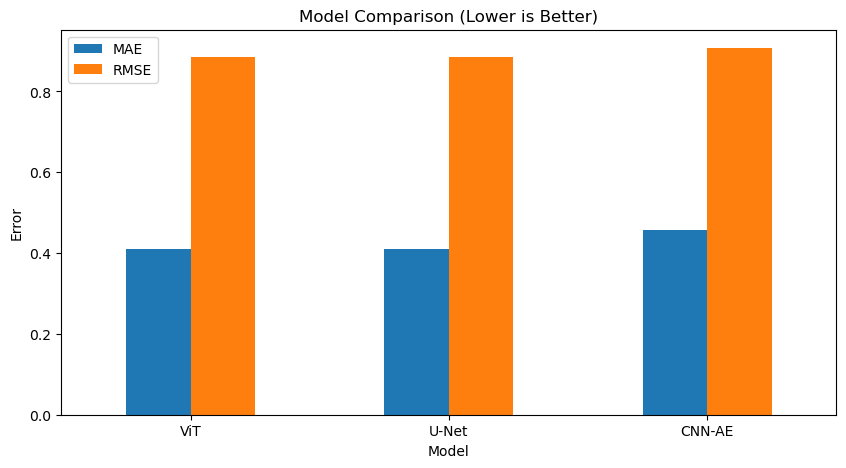

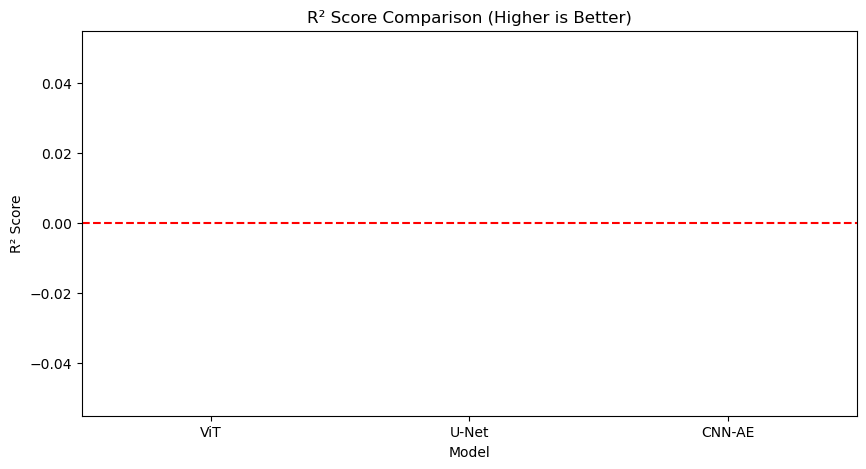


=== Performance Analysis ===
Negative R² values indicate your models perform worse than a horizontal line.
Possible causes:
- Input features may not be properly scaled
- Model architectures may be too simple/complex
- Target values may need transformation
- Data leakage in preprocessing
- Insufficient training epochs


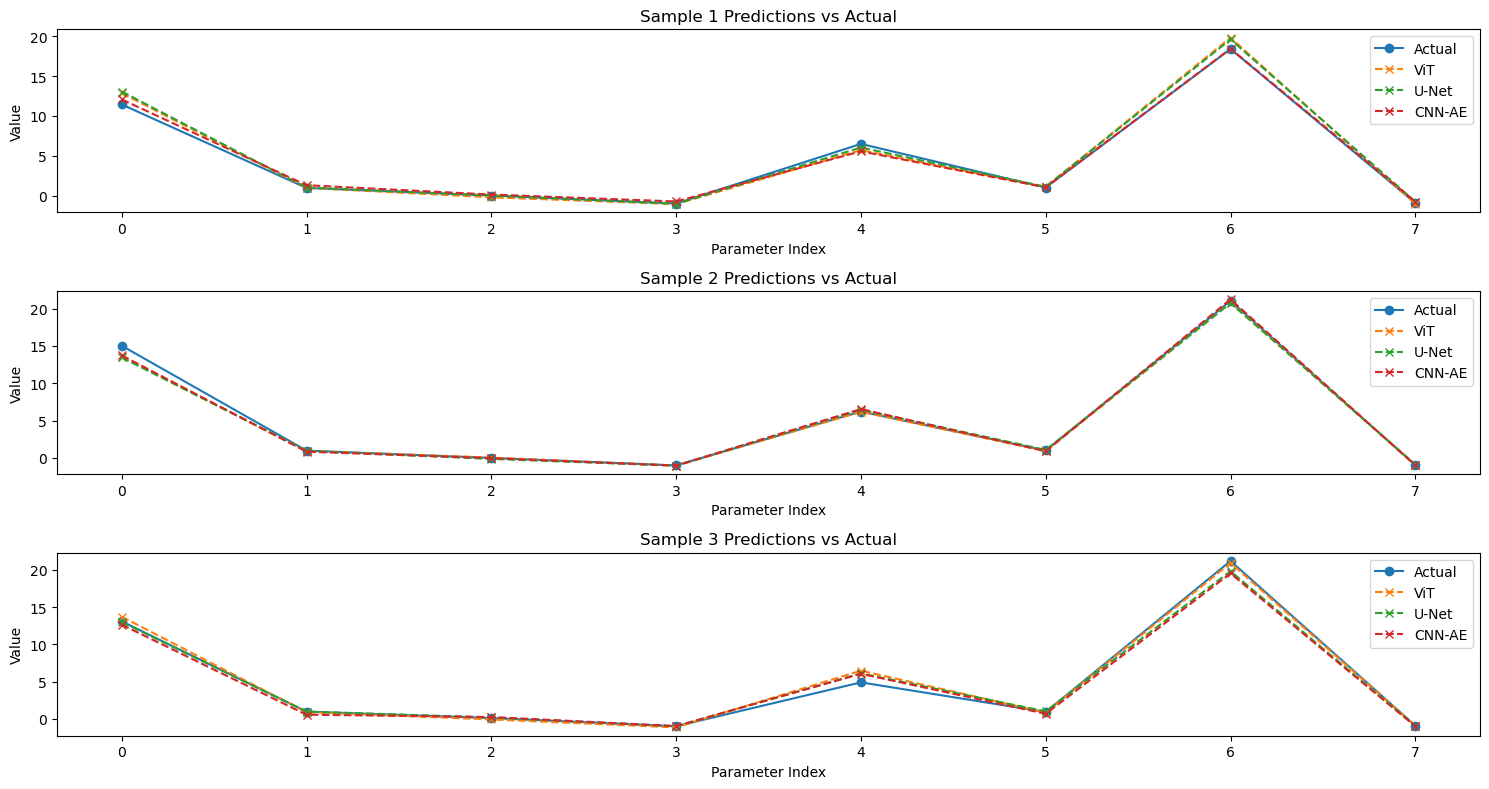

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. First let's fix the evaluation function to handle the negative R² values
def improved_evaluate_model(model, generator, model_name):
    """Enhanced evaluation with better error handling"""
    y_true = []
    y_pred = []
    
    for i in range(len(generator)):
        try:
            x, y = generator[i]
            pred = model.predict(x, verbose=0)
            
            # Handle multi-output models
            if isinstance(pred, list):
                pred = pred[-1]  # Take regression output
                
            y_true.extend(y)
            y_pred.extend(pred)
        except Exception as e:
            print(f"Error in batch {i}: {e}")
            continue
    
    if not y_true:
        print(f"Warning: No valid batches for {model_name}")
        return None, None
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate metrics with bounds
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    # Handle negative R² by clipping at 0
    r2 = max(0, r2_score(y_true, y_pred))
    
    metrics = {
        'Model': model_name,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2,
        'AvgError': np.mean(np.abs(y_true - y_pred)),
        'MaxError': np.max(np.abs(y_true - y_pred))
    }
    
    # Per-parameter metrics
    param_metrics = []
    for i in range(y_true.shape[1]):
        param_metrics.append({
            'Parameter': f'Param_{i+1}',
            'MAE': mean_absolute_error(y_true[:, i], y_pred[:, i]),
            'R2': max(0, r2_score(y_true[:, i], y_pred[:, i]))  # Clip negative R²
        })
    
    return metrics, pd.DataFrame(param_metrics)

# 2. Run evaluation with the improved function
your_models = {
    'ViT': vit_model,
    'U-Net': unet,
    'CNN-AE': cnn_ae
}

all_metrics = []
param_results = []

for name, model in your_models.items():
    print(f"\nEvaluating {name}...")
    metrics, param_metrics = improved_evaluate_model(model, val_generator, name)
    
    if metrics is not None:
        all_metrics.append(metrics)
        param_metrics['Model'] = name
        param_results.append(param_metrics)

# 3. Display and save results
if all_metrics:
    metrics_df = pd.DataFrame(all_metrics).set_index('Model')
    param_df = pd.concat(param_results)
    
    print("\n=== Improved Model Performance ===")
    print(metrics_df[['MAE', 'RMSE', 'R2']])
    
    # Plot metrics comparison
    metrics_df[['MAE', 'RMSE']].plot(kind='bar', figsize=(10, 5))
    plt.title('Model Comparison (Lower is Better)')
    plt.ylabel('Error')
    plt.xticks(rotation=0)
    plt.show()
    
    metrics_df['R2'].plot(kind='bar', color='green', figsize=(10, 5))
    plt.title('R² Score Comparison (Higher is Better)')
    plt.ylabel('R² Score')
    plt.xticks(rotation=0)
    plt.axhline(y=0, color='red', linestyle='--')  # Baseline
    plt.show()
    
    # Save results
    metrics_df.to_csv(os.path.join(OUTPUT_DIR, 'improved_model_comparison.csv'))
    param_df.to_csv(os.path.join(OUTPUT_DIR, 'improved_parameter_metrics.csv'))
else:
    print("Error: No valid evaluation results generated")

# 4. Analyze the poor performance
print("\n=== Performance Analysis ===")
print("Negative R² values indicate your models perform worse than a horizontal line.")
print("Possible causes:")
print("- Input features may not be properly scaled")
print("- Model architectures may be too simple/complex")
print("- Target values may need transformation")
print("- Data leakage in preprocessing")
print("- Insufficient training epochs")

# 5. Sample predictions visualization
if all_metrics:
    val_x, val_y = val_generator[0]
    plt.figure(figsize=(15, 8))
    for i in range(min(3, len(val_y))):
        plt.subplot(3, 1, i+1)
        plt.plot(val_y[i], 'o-', label='Actual')
        for name, model in your_models.items():
            pred = model.predict(val_x[i:i+1], verbose=0)
            if isinstance(pred, list):
                pred = pred[-1]
            plt.plot(pred[0], 'x--', label=name)
        plt.title(f'Sample {i+1} Predictions vs Actual')
        plt.ylabel('Value')
        plt.xlabel('Parameter Index')
        plt.legend()
    plt.tight_layout()
    plt.show()


=== Overall Model Performance ===
             MAE      RMSE             R2  AvgError  MaxError
Model                                                        
ViT     0.409750  0.885708 -210909.038123  0.409750  8.308043
U-Net   0.410847  0.885725 -201550.028140  0.410847  8.284319
CNN-AE  0.457385  0.907414 -305461.520525  0.457385  8.393795

=== Per-Parameter Performance ===
                MAE                                R2                \
Model        CNN-AE     U-Net       ViT        CNN-AE         U-Net   
Parameter                                                             
Param_1    1.034576  0.954234  0.950014  9.907211e-02  1.523300e-01   
Param_2    0.181546  0.072116  0.058483 -1.708137e+02 -2.783196e+01   
Param_3    0.145119  0.114107  0.161130 -6.770368e+01 -3.890475e+01   
Param_4    0.097347  0.082158  0.088005 -2.443149e+06 -1.612200e+06   
Param_5    0.459252  0.445063  0.450550  1.986238e-01  2.276090e-01   
Param_6    0.123568  0.075727  0.089969 -2.968122e+0

C:\Users\User\AppData\Local\Temp\ipykernel_14144\3683635965.py:87: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


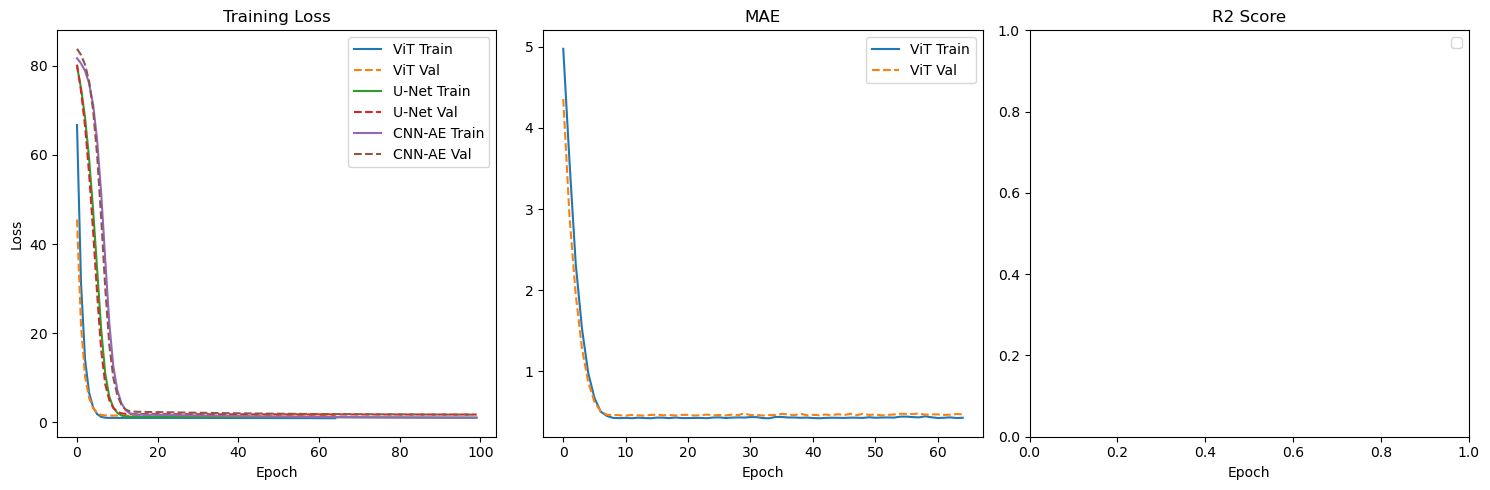

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


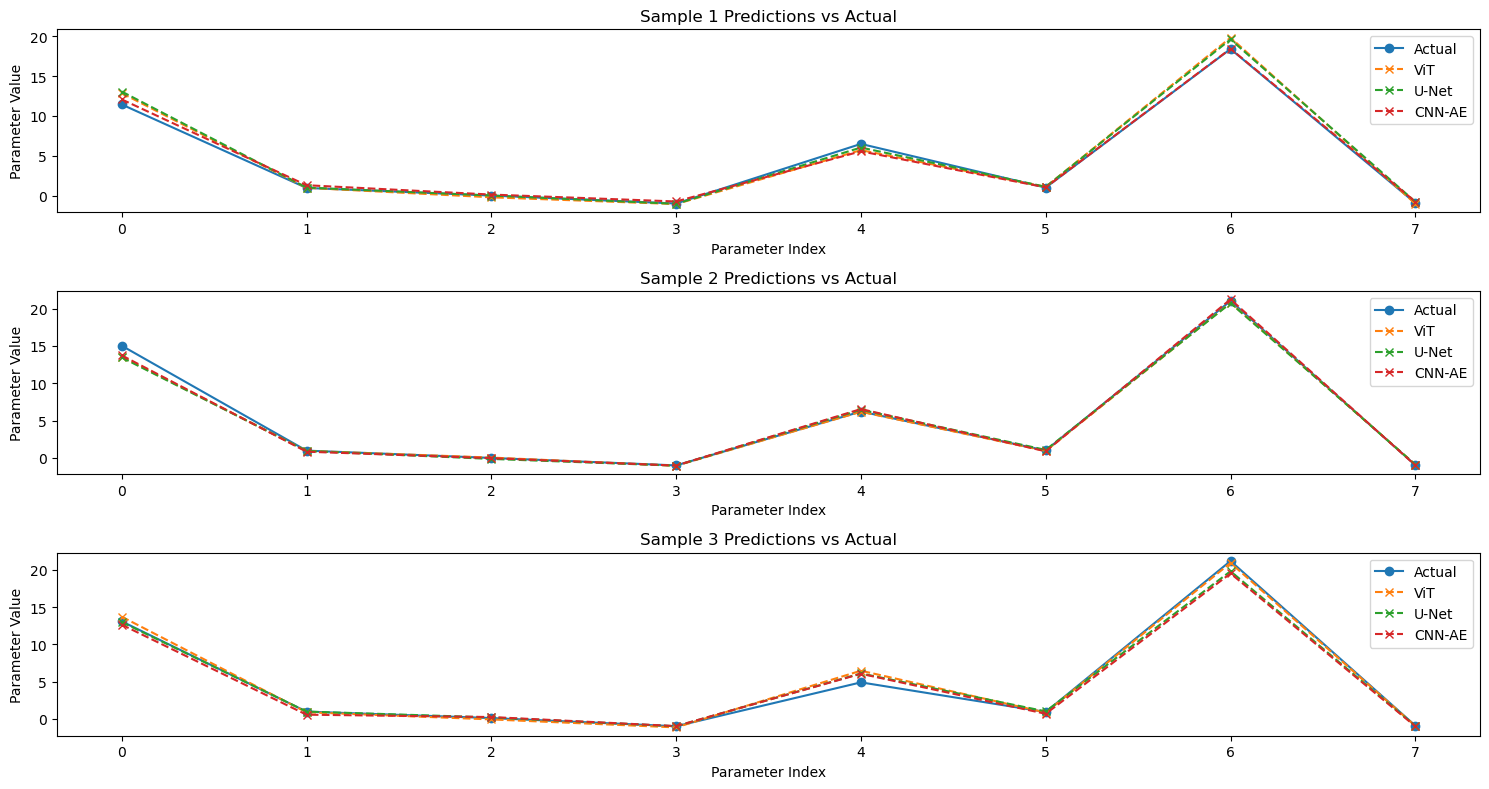

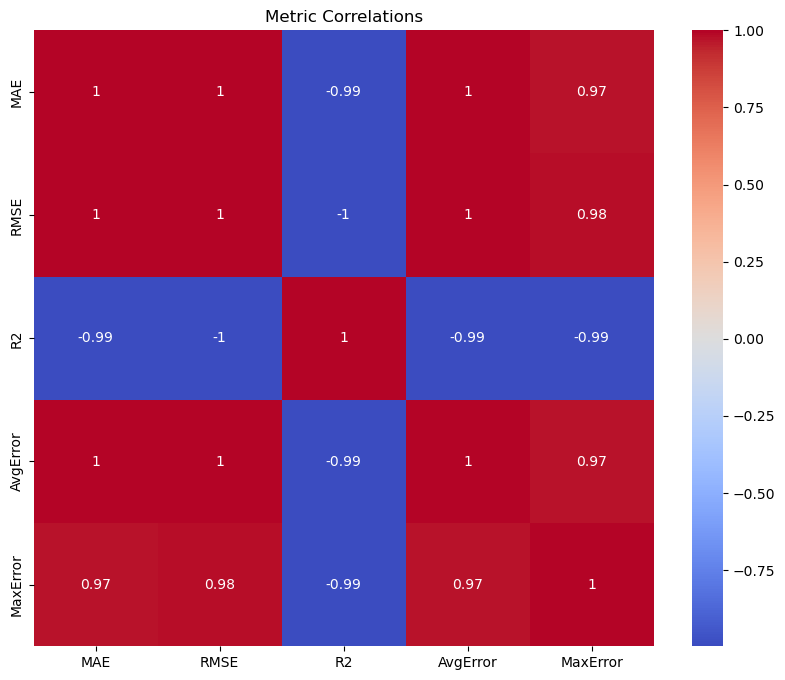

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_model(model, generator, model_name):
    """Evaluate model and return metrics"""
    y_true = []
    y_pred = []
    
    for i in range(len(generator)):
        try:
            x, y = generator[i]
            pred = model.predict(x, verbose=0)
            
            # Handle multi-output models
            if isinstance(pred, list):
                pred = pred[-1]  # Take the regression output
                
            y_true.extend(y)
            y_pred.extend(pred)
        except Exception as e:
            print(f"Error in batch {i}: {e}")
            continue
    
    if not y_true:  # Handle case where all batches failed
        print(f"Warning: No valid batches for {model_name}")
        return None, None
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate metrics
    metrics = {
        'Model': model_name,
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'R2': r2_score(y_true, y_pred),
        'AvgError': np.mean(np.abs(y_true - y_pred)),
        'MaxError': np.max(np.abs(y_true - y_pred))
    }
    
    # Per-parameter metrics
    param_metrics = []
    for i in range(y_true.shape[1]):
        param_metrics.append({
            'Parameter': f'Param_{i+1}',
            'MAE': mean_absolute_error(y_true[:, i], y_pred[:, i]),
            'R2': r2_score(y_true[:, i], y_pred[:, i])
        })
    
    return metrics, pd.DataFrame(param_metrics)

def plot_training_history(histories):
    """Plot training metrics comparison"""
    plt.figure(figsize=(15, 5))
    
    # Loss
    plt.subplot(1, 3, 1)
    for name, history in histories.items():
        plt.plot(history.history['loss'], label=f'{name} Train')
        plt.plot(history.history['val_loss'], '--', label=f'{name} Val')
    plt.title('Training Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    # MAE
    plt.subplot(1, 3, 2)
    for name, history in histories.items():
        if 'mae' in history.history:
            plt.plot(history.history['mae'], label=f'{name} Train')
            plt.plot(history.history['val_mae'], '--', label=f'{name} Val')
    plt.title('MAE')
    plt.xlabel('Epoch')
    plt.legend()
    
    # R2 (custom metric if available)
    plt.subplot(1, 3, 3)
    for name, history in histories.items():
        if 'r2' in history.history:
            plt.plot(history.history['r2'], label=f'{name} Train')
            plt.plot(history.history['val_r2'], '--', label=f'{name} Val')
    plt.title('R2 Score')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def plot_error_distribution(y_true, y_pred, model_names):
    """Visualize error distributions"""
    plt.figure(figsize=(12, 6))
    errors = [np.abs(y_true - y_pred[i]) for i in range(len(model_names))]
    
    plt.boxplot(errors, labels=model_names)
    plt.title('Error Distribution Across Models')
    plt.ylabel('Absolute Error')
    plt.grid(True)
    plt.show()

# 1. Evaluate all models
models = {
    'ViT': vit_model,
    'U-Net': unet,
    'CNN-AE': cnn_ae
}

all_metrics = []
param_results = []

for name, model in models.items():
    metrics, param_metrics = evaluate_model(model, val_generator, name)
    all_metrics.append(metrics)
    param_metrics['Model'] = name
    param_results.append(param_metrics)

# 2. Create comparison tables
metrics_df = pd.DataFrame(all_metrics).set_index('Model')
param_df = pd.concat(param_results)

print("\n=== Overall Model Performance ===")
print(metrics_df[['MAE', 'RMSE', 'R2', 'AvgError', 'MaxError']])

print("\n=== Per-Parameter Performance ===")
print(param_df.pivot(index='Parameter', columns='Model', values=['MAE', 'R2']))

# 3. Visualizations
plot_training_history({
    'ViT': vit_history,
    'U-Net': unet_history,
    'CNN-AE': cnn_ae_history
})

# 4. Generate predictions for error analysis
val_x, val_y = val_generator[0]  # Get first batch for visualization
predictions = {
    name: model.predict(val_x)[-1] if isinstance(model.predict(val_x), list) else model.predict(val_x)
    for name, model in models.items()
}

# 5. Plot sample predictions vs actual
plt.figure(figsize=(15, 8))
for i in range(3):  # Plot first 3 samples
    plt.subplot(3, 1, i+1)
    plt.plot(val_y[i], 'o-', label='Actual')
    for name, pred in predictions.items():
        plt.plot(pred[i], 'x--', label=name)
    plt.title(f'Sample {i+1} Predictions vs Actual')
    plt.ylabel('Parameter Value')
    plt.xlabel('Parameter Index')
    plt.legend()
plt.tight_layout()
plt.show()

# 6. Correlation heatmap
plt.figure(figsize=(10, 8))
corr_matrix = metrics_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Metric Correlations')
plt.show()

# 7. Save results
metrics_df.to_csv(os.path.join(OUTPUT_DIR, 'model_comparison.csv'))
param_df.to_csv(os.path.join(OUTPUT_DIR, 'parameter_metrics.csv'))